In [14]:
import pandas as pd
import numpy as np
import random
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import torch
from transformers import MarianMTModel, MarianTokenizer, T5ForConditionalGeneration, T5Tokenizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [15]:
df = pd.read_csv('/home/Genai/project/Data/Dataset 11000 Reviews.tsv', sep='\t', header=None)
df.columns = ['sentiment', 'review']
seed_df = df.sample(n=100, random_state=42).reset_index(drop=True)
seed_df.head()

,sentiment,review
0,neg,@ anonymous urf shezad .. tum nay bhi to meri...
1,pos,ab hamin kon khilae ga bana kar balke hafsa q ...
2,pos,muskan sis ho bahi nahi girls behi patang urht...
3,neg,koi patwari issy btay agar sabit hoa tu yeh ja...
4,neg,bhot acha hoa in ka sath asi hona chaiya tha l...


Total reviews in dataset: 11000
Reviews by sentiment:
sentiment
pos    5699
neg    5300
          1
Name: count, dtype: int64


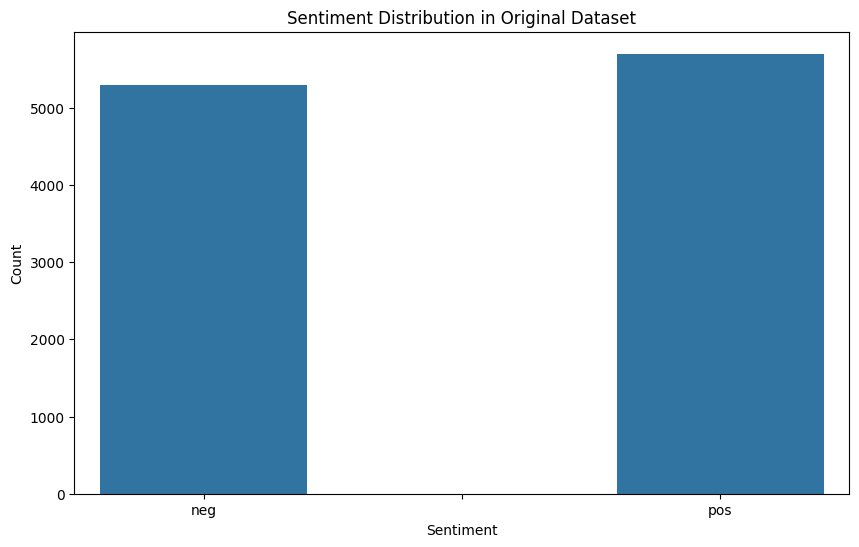

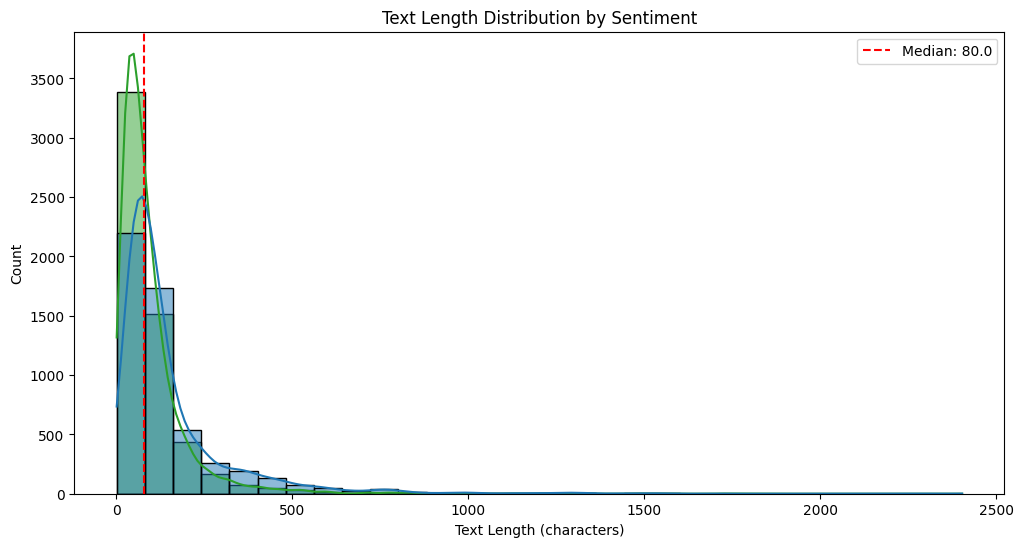

Text Length Statistics:
            count        mean         std   min   25%   50%    75%     max
sentiment                                                                 
              1.0   99.000000         NaN  99.0  99.0  99.0   99.0    99.0
neg        5300.0  150.317736  171.438237   6.0  58.0  96.0  167.0  2403.0
pos        5699.0   96.031058  108.054794   1.0  37.0  67.0  115.0  1730.0


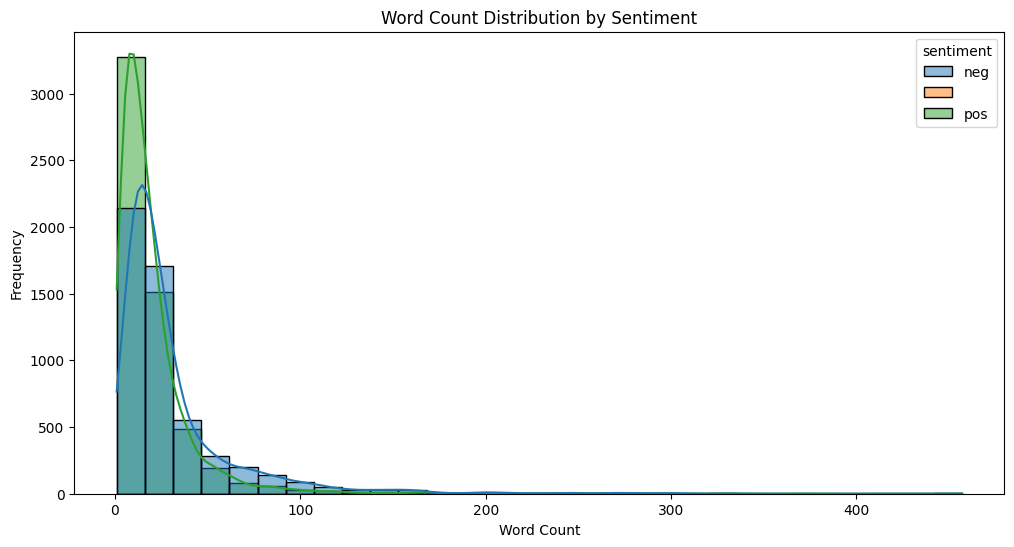

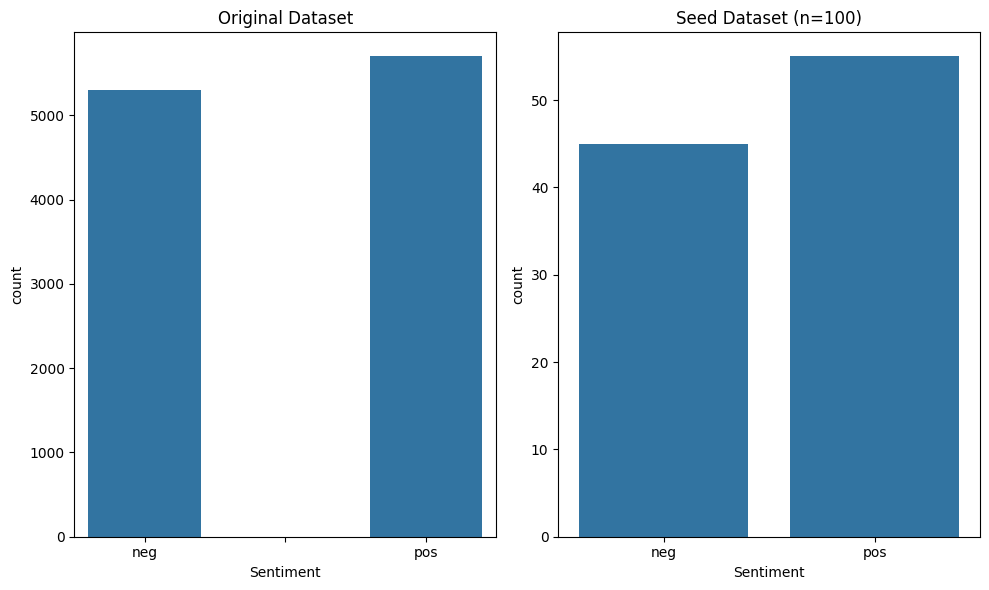

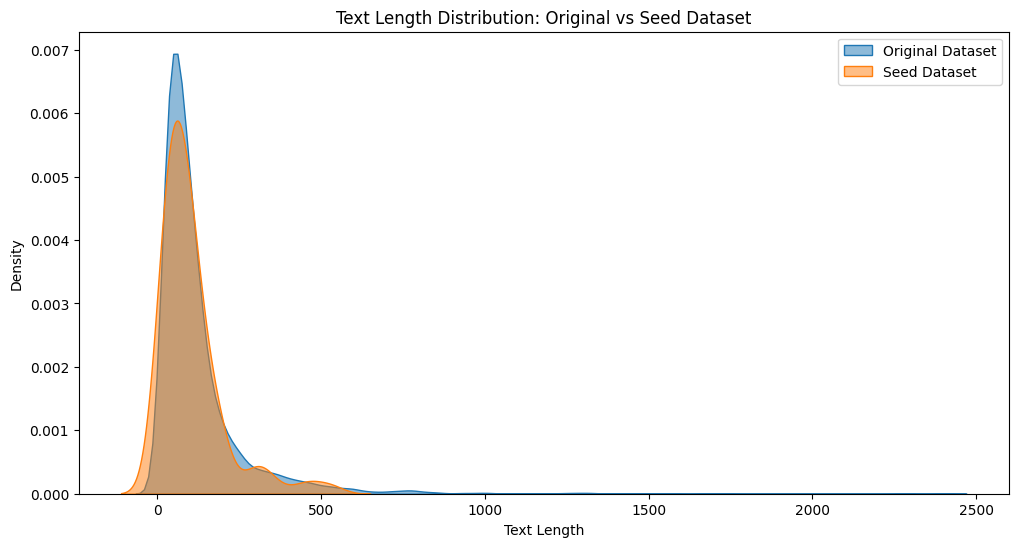

In [16]:
# 1.1 Exploratory Data Analysis and Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Create directory for saving visualizations
os.makedirs('Images', exist_ok=True)

# Overall dataset stats
print(f"Total reviews in dataset: {len(df)}")
print(f"Reviews by sentiment:")
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment')
plt.title('Sentiment Distribution in Original Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.savefig('Images/sentiment_distribution.png')
plt.show()

# Analyze text length
df['text_length'] = df['review'].apply(len)
seed_df['text_length'] = seed_df['review'].apply(len)

# Plot text length distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', hue='sentiment', bins=30, kde=True)
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Text Length (characters)')
plt.ylabel('Count')
plt.axvline(x=df['text_length'].median(), color='red', linestyle='--', label=f'Median: {df["text_length"].median()}')
plt.legend()
plt.savefig('Images/text_length_distribution.png')
plt.show()

# Summary statistics of text length
print("Text Length Statistics:")
print(df.groupby('sentiment')['text_length'].describe())

# Word count analysis
df['word_count'] = df['review'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', hue='sentiment', bins=30, kde=True)
plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.savefig('Images/word_count_distribution.png')
plt.show()

# Compare the seed dataset with original dataset
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='sentiment')
plt.title('Original Dataset')
plt.xlabel('Sentiment')

plt.subplot(1, 2, 2)
sns.countplot(data=seed_df, x='sentiment')
plt.title('Seed Dataset (n=100)')
plt.xlabel('Sentiment')

plt.tight_layout()
plt.savefig('Images/seed_vs_original_distribution.png')
plt.show()

# Visualize text length distribution in seed vs full dataset
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='text_length', label='Original Dataset', fill=True, alpha=0.5)
sns.kdeplot(data=seed_df, x='text_length', label='Seed Dataset', fill=True, alpha=0.5)
plt.title('Text Length Distribution: Original vs Seed Dataset')
plt.xlabel('Text Length')
plt.legend()
plt.savefig('Images/text_length_comparison.png')
plt.show()

In [17]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").lower()
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(sentence, n=2):
    words = word_tokenize(sentence)
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word.isalpha()]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) > 0:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

def random_insertion(sentence, n=2):
    words = word_tokenize(sentence)
    for _ in range(n):
        add_word(words)
    return ' '.join(words)

def add_word(words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1 and counter < 10:
        random_word = random.choice(words)
        synonyms = get_synonyms(random_word)
        counter += 1
    if len(synonyms) > 0:
        random_synonym = random.choice(synonyms)
        insert_pos = random.randint(0, len(words))
        words.insert(insert_pos, random_synonym)

def random_swap(sentence, n=2):
    words = word_tokenize(sentence)
    for _ in range(n):
        words = swap_word(words)
    return ' '.join(words)

def swap_word(words):
    if len(words) < 2:
        return words
    idx1, idx2 = random.sample(range(len(words)), 2)
    words[idx1], words[idx2] = words[idx2], words[idx1]
    return words

def random_deletion(sentence, p=0.1):
    words = word_tokenize(sentence)
    if len(words) == 1:
        return sentence
    new_words = [word for word in words if random.uniform(0,1) > p]
    if len(new_words) == 0:
        return random.choice(words)
    else:
        return ' '.join(new_words)

In [4]:
print(seed_df.columns)

Index(['sentiment', 'review'], dtype='object')


In [18]:
seed_df['synonym_replacement'] = seed_df['review'].apply(lambda x: synonym_replacement(str(x), n=2))
seed_df['random_insertion'] = seed_df['review'].apply(lambda x: random_insertion(str(x), n=2))
seed_df['random_swap'] = seed_df['review'].apply(lambda x: random_swap(str(x), n=2))
seed_df['random_deletion'] = seed_df['review'].apply(lambda x: random_deletion(str(x), p=0.1))
seed_df[['review', 'synonym_replacement', 'random_insertion', 'random_swap', 'random_deletion']].head()

,review,synonym_replacement,random_insertion,random_swap,random_deletion
0,@ anonymous urf shezad .. tum nay bhi to meri...,@ anonymous urf shezad .. tum nay bhi to meri ...,@ anonymous urf shezad .. tum nay bhi to meri ...,@ anonymous tum shezad .. urf nay bhi to meri ...,@ anonymous urf shezad .. tum nay bhi to meri ...
1,ab hamin kon khilae ga bana kar balke hafsa q ...,abdominal muscle hamin kon khilae georgia bana...,ab hamin kon khilae ga bana kar balke hawai'i ...,ab hamin kon khilae ga ; ) balke hafsa q trkib...,ab hamin kon khilae ga kar balke hafsa q trkib...
2,muskan sis ho bahi nahi girls behi patang urht...,muskan sis holmium bahi nahi missy behi patang...,atomic number 67 muskan sis ho bahi nahi girls...,muskan sis urhtaayi bahi nahi girls behi patan...,muskan sis ho bahi nahi girls behi patang urht...
3,koi patwari issy btay agar sabit hoa tu yeh ja...,koi patwari issy btay nutrient agar sabit hoa ...,koi patwari issy btay agar sabit hoa tu yeh ja...,koi patwari issy btay agar sabit hoa tu yeh b ...,koi patwari issy btay agar sabit hoa tu yeh ja...
4,bhot acha hoa in ka sath asi hona chaiya tha l...,bhot acha hoa indium ka sath asi hona chaiya t...,bhot acha hoa in ka sath asi hona inwards chai...,bhot acha hoa in ka lanti asi hona chaiya tha ...,bhot acha hoa in sath asi hona chaiya tha lant...


In [6]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

/home/Genai/project/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
import random
import pandas as pd

# Assuming seed_df is provided with columns: 'review', 'sentiment', 'synonym_replacement'
paraphrase_examples = seed_df.sample(2, random_state=42)
negative_examples = seed_df[seed_df['sentiment'] == 'neg'].sample(2, random_state=42)
positive_examples = seed_df[seed_df['sentiment'] == 'pos'].sample(2, random_state=42)

In [8]:
def generate_paraphrase(text, num_return_sequences=1):
    prompt = "Paraphrase the following text in Roman Urdu:\n\n"
    for idx, row in paraphrase_examples.iterrows():
        prompt += f"Original: {row['review']}\nParaphrase: {row['synonym_replacement']}\n\n"
    prompt += f"Original: {text}\nParaphrase:"

    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(
        **inputs,
        max_length=150,
        num_return_sequences=num_return_sequences,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.7
    )
    paraphrases = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return paraphrases[0] if num_return_sequences == 1 else paraphrases

def generate_conditional_text(sentiment, num_return_sequences=1):
    examples = negative_examples if sentiment == 'neg' else positive_examples
    prompt = f"Generate a {sentiment} sentiment text in Roman Urdu.\n\n"
    for idx, row in examples.iterrows():
        prompt += f"Example: {row['review']}\n\n"
    prompt += "New text:"

    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(
        **inputs,
        max_length=150,
        num_return_sequences=num_return_sequences,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.7
    )
    texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return texts[0] if num_return_sequences == 1 else texts

In [9]:
seed_df['paraphrase'] = seed_df['review'].apply(lambda x: generate_paraphrase(x))

num_synthetic_per_sentiment = 50
synthetic_neg = generate_conditional_text('neg', num_return_sequences=num_synthetic_per_sentiment)
synthetic_pos = generate_conditional_text('pos', num_return_sequences=num_synthetic_per_sentiment)

conditional_synthetic_df = pd.DataFrame({
    'review': synthetic_neg + synthetic_pos,
    'sentiment': ['neg'] * num_synthetic_per_sentiment + ['pos'] * num_synthetic_per_sentiment
})

synthetic_reviews = []
synthetic_sentiments = []

for col in ['synonym_replacement', 'random_insertion', 'random_swap', 'random_deletion', 'paraphrase']:
    synthetic_reviews.extend(seed_df[col].tolist())
    synthetic_sentiments.extend(seed_df['sentiment'].tolist())

synthetic_reviews.extend(conditional_synthetic_df['review'].tolist())
synthetic_sentiments.extend(conditional_synthetic_df['sentiment'].tolist())

initial_synthetic_df = pd.DataFrame({
    'review': synthetic_reviews,
    'sentiment': synthetic_sentiments
})

In [19]:
import fasttext
import os

os.makedirs('Models/fasttext_data', exist_ok=True)
with open('Models/fasttext_data/seed_train.txt', 'w') as f:
    for idx, row in seed_df.iterrows():
        label = '__label__' + row['sentiment']
        text = row['review'].replace('\n', ' ')
        f.write(f"{label} {text}\n")

classifier = fasttext.train_supervised(input='Models/fasttext_data/seed_train.txt', epoch=25, lr=1.0, wordNgrams=2)

Read 0M words
Number of words:  1086
Number of labels: 2
Progress: 100.0% words/sec/thread:   51354 lr:  0.000000 avg.loss:  0.140536 ETA:   0h 0m 0s


In [ ]:
# 2.2 Set Up and Train RL Loop with trl library
from trl import PPOConfig, AutoModelForSeq2SeqLMWithValueHead, PPOTrainer
from torch.utils.data import Dataset
import re
import torch
from tqdm import tqdm
import gc
import math

# Ensure GPU is available and memory cleanup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
gc.collect()

# Create a model with value head for PPO
model_with_value_head = AutoModelForSeq2SeqLMWithValueHead.from_pretrained("t5-small")
model_with_value_head.to(device)

# PPO configuration optimized for 6GB VRAM with KL stability improvements
ppo_config = PPOConfig(
    model_name="t5-small",
    learning_rate=5e-6,  # Reduced learning rate for stability
    batch_size=1,
    mini_batch_size=1,
    ppo_epochs=4,
    gradient_accumulation_steps=1,
    kl_penalty="kl",  # Add KL penalty to address negative KL
    init_kl_coef=0.2,  # KL coefficient for stability
    adap_kl_ctrl=True  # Adaptive KL control
)

def get_reward(text, target_sentiment):
    # Make sure text isn't empty
    if not text or len(text.strip()) == 0:
        print("Empty response detected, assigning zero reward")
        return 0.0
        
    try:
        labels, probabilities = classifier.predict(text, k=2)
        label_prob_dict = dict(zip(labels, probabilities))
        target_label = '__label__' + target_sentiment
        reward = label_prob_dict.get(target_label, 0.0)
        
        # Thorough reward sanitization
        if not isinstance(reward, float) or math.isnan(reward) or math.isinf(reward) or reward < 0:
            print(f"Invalid reward ({reward}) for response: {text[:50]}...")
            return 0.0
            
        return reward
    except Exception as e:
        print(f"Error in reward calculation: {str(e)}, text: {text[:50]}...")
        return 0.0

def create_prompts(sentiment, num_prompts):
    examples_df = seed_df[seed_df['sentiment'] == sentiment]
    prompts = []
    for _ in range(num_prompts):
        examples = examples_df.sample(2)
        prompt = f"Generate a {sentiment} sentiment text in Roman Urdu.\n\n"
        for idx, row in examples.iterrows():
            prompt += f"Example: {row['review']}\n\n"
        prompt += "New text:"
        prompts.append(prompt)
    return prompts

# Create dataset with the required field names for PPOTrainer
class PPODataset(Dataset):
    def __init__(self, input_ids, attention_mask, prompts, sentiments):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.prompts = prompts
        self.sentiments = sentiments
        
    def __len__(self):
        return len(self.prompts)
    
    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx], 
            "prompt": self.prompts[idx],
            "sentiment": self.sentiments[idx]
        }

# Prepare prompts and targets
num_prompts_per_sentiment = 50
neg_prompts = create_prompts('neg', num_prompts_per_sentiment)
pos_prompts = create_prompts('pos', num_prompts_per_sentiment)
all_prompts = neg_prompts + pos_prompts
target_sentiments = ['neg'] * num_prompts_per_sentiment + ['pos'] * num_prompts_per_sentiment

# Tokenize prompts
tokenized_prompts = tokenizer(all_prompts, padding=True, truncation=True, return_tensors="pt")
dataset = PPODataset(
    tokenized_prompts['input_ids'], 
    tokenized_prompts['attention_mask'],
    all_prompts,
    target_sentiments
)

# Create the PPO trainer
trainer = PPOTrainer(
    config=ppo_config,
    model=model_with_value_head,
    tokenizer=tokenizer
)

# Track successful examples for debugging
successful_examples = 0
total_reward = 0.0

# PPO RL Loop
for epoch in range(4):
    print(f"Epoch {epoch + 1}/4")
    epoch_reward = 0.0
    epoch_examples = 0
    
    for idx in tqdm(range(len(dataset))):
        try:
            example = dataset[idx]
            query_tensor = example["input_ids"].unsqueeze(0).to(device)
            attention_mask = example["attention_mask"].unsqueeze(0).to(device)

            # Generate response with more conservative parameters
            with torch.no_grad():
                response_tensor = model_with_value_head.generate(
                    input_ids=query_tensor,
                    attention_mask=attention_mask,
                    max_length=100,
                    min_length=10,  # Ensure some minimal output
                    do_sample=True,
                    top_k=50,
                    top_p=0.95,
                    temperature=0.9,  # Slightly higher for more exploration
                    no_repeat_ngram_size=2  # Reduce repetition
                )

            decoded_response = tokenizer.decode(response_tensor[0], skip_special_tokens=True)
            sentiment = example["sentiment"]
            reward = get_reward(decoded_response, sentiment)
            
            # Skip very low rewards - they don't provide good training signal
            if reward < 0.05:
                print(f"Skipping example {idx} with very low reward: {reward:.4f}")
                continue
                
            rewards_tensor = torch.tensor([reward], device=device)

            # Pass lists of 1D tensors as required by PPOTrainer
            stats = trainer.step([query_tensor[0]], [response_tensor[0]], [rewards_tensor])
            
            successful_examples += 1
            total_reward += reward
            epoch_reward += reward
            epoch_examples += 1

            if idx % 10 == 0:
                print(f"Example {idx}, Reward: {reward:.4f}")
                torch.cuda.empty_cache()

        except Exception as e:
            print(f"Error on example {idx}: {str(e)}")
            torch.cuda.empty_cache()
            continue
    
    # Print epoch stats
    avg_epoch_reward = epoch_reward / max(1, epoch_examples)
    print(f"Epoch {epoch+1} complete - Avg reward: {avg_epoch_reward:.4f}")
    
    # More aggressive cleanup between epochs
    gc.collect()
    torch.cuda.empty_cache()

# Final stats
avg_reward = total_reward / max(1, successful_examples)
print(f"Training complete - {successful_examples}/{len(dataset)*4} examples processed successfully")
print(f"Average reward: {avg_reward:.4f}")

# Save the fine-tuned model
model_with_value_head.pretrained_model.save_pretrained("Models/ppo_t5_small")
tokenizer.save_pretrained("Models/ppo_t5_small")

/home/Genai/project/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/models/modeling_base.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by t

Epoch 1/4


  0%|          | 0/100 [00:00<?, ?it/s]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1275: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  std_scores = data["scores"].std()
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1302: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  stats["tokens/queries_len_std"] = torch.std(query_lens).cpu().numpy().item()
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1305: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel)

Example 0, Reward: 0.9531


  5%|▌         | 5/100 [00:10<03:24,  2.16s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.26 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
  7%|▋         | 7/100 [00:13<02:44,  1.76s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.27 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 11%|█         | 11/100 [00:17<02:05,  1.41s/it]

Example 10, Reward: 0.7894


 16%|█▌        | 16/100 [00:29<02:33,  1.83s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.66 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 21%|██        | 21/100 [00:40<02:42,  2.06s/it]

Example 20, Reward: 0.1750


 22%|██▏       | 22/100 [00:43<02:58,  2.29s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.57 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 27%|██▋       | 27/100 [00:49<01:52,  1.54s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.21 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 29%|██▉       | 29/100 [00:53<02:18,  1.94s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl

Example 30, Reward: 0.9275


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -4.26 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 41%|████      | 41/100 [01:13<00:55,  1.07it/s]

Example 40, Reward: 0.6146


 42%|████▏     | 42/100 [01:14<01:03,  1.09s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.95 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 44%|████▍     | 44/100 [01:18<01:17,  1.39s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.91 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 46%|████▌     | 46/100 [01:24<01:46,  1.97s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl

Skipping example 47 with very low reward: 0.0020


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.75 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 51%|█████     | 51/100 [01:30<01:15,  1.54s/it]

Example 50, Reward: 0.8186


 55%|█████▌    | 55/100 [01:39<01:36,  2.15s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.78 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 57%|█████▋    | 57/100 [01:43<01:27,  2.03s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.23 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 58%|█████▊    | 58/100 [01:44<01:16,  1.82s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl

Example 60, Reward: 0.9083


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.94 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 62%|██████▏   | 62/100 [01:53<01:25,  2.26s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5.76 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 65%|██████▌   | 65/100 [01:59<01:18,  2.26s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL di

Example 70, Reward: 0.6387


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -16.89 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 74%|███████▍  | 74/100 [02:13<00:41,  1.59s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.07 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 77%|███████▋  | 77/100 [02:20<00:49,  2.17s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL d

Example 80, Reward: 0.9164


 86%|████████▌ | 86/100 [02:40<00:25,  1.85s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.14 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 88%|████████▊ | 88/100 [02:41<00:14,  1.19s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5.10 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 89%|████████▉ | 89/100 [02:44<00:19,  1.75s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl

Example 90, Reward: 0.9872


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5.11 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 96%|█████████▌| 96/100 [02:57<00:07,  1.82s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.35 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
100%|██████████| 100/100 [03:07<00:00,  1.88s/it]


Epoch 1 complete - Avg reward: 0.7914
Epoch 2/4


  1%|          | 1/100 [00:00<00:31,  3.10it/s]

Example 0, Reward: 0.3430


  9%|▉         | 9/100 [00:17<03:19,  2.19s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -12.79 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 11%|█         | 11/100 [00:20<02:48,  1.89s/it]

Example 10, Reward: 0.9104


 12%|█▏        | 12/100 [00:22<02:41,  1.83s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.46 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 13%|█▎        | 13/100 [00:24<02:48,  1.94s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.73 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 20%|██        | 20/100 [00:37<02:13,  1.67s/it]

Skipping example 19 with very low reward: 0.0493


 21%|██        | 21/100 [00:38<01:54,  1.45s/it]

Example 20, Reward: 0.0886


 31%|███       | 31/100 [00:56<01:36,  1.40s/it]

Skipping example 30 with very low reward: 0.0279


 32%|███▏      | 32/100 [00:58<01:48,  1.60s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.23 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 33%|███▎      | 33/100 [01:00<01:46,  1.59s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -4.33 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Skipping example 34 with very low reward: 0.0118


 38%|███▊      | 38/100 [01:05<01:21,  1.31s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.49 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 41%|████      | 41/100 [01:10<01:40,  1.70s/it]

Example 40, Reward: 0.8326


 44%|████▍     | 44/100 [01:15<01:31,  1.63s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.15 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 47%|████▋     | 47/100 [01:22<01:57,  2.23s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5.69 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 51%|█████     | 51/100 [01:29<01:15,  1.53s/it]

Example 50, Reward: 0.9488


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3.37 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 56%|█████▌    | 56/100 [01:39<01:19,  1.81s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.34 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 60%|██████    | 60/100 [01:46<01:04,  1.61s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL di

Example 60, Reward: 0.3837


 71%|███████   | 71/100 [02:01<00:34,  1.20s/it]

Example 70, Reward: 0.9483


 72%|███████▏  | 72/100 [02:02<00:34,  1.24s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5.79 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 73%|███████▎  | 73/100 [02:04<00:37,  1.40s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -4.13 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 75%|███████▌  | 75/100 [02:07<00:36,  1.47s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl

Example 80, Reward: 0.9873


 91%|█████████ | 91/100 [02:34<00:12,  1.39s/it]

Example 90, Reward: 0.9706


 93%|█████████▎| 93/100 [02:38<00:11,  1.71s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.48 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 95%|█████████▌| 95/100 [02:42<00:08,  1.78s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5.20 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
100%|██████████| 100/100 [02:56<00:00,  1.76s/it]


Epoch 2 complete - Avg reward: 0.7740
Epoch 3/4


  0%|          | 0/100 [00:00<?, ?it/s]

Example 0, Reward: 0.9026


  5%|▌         | 5/100 [00:04<01:25,  1.10it/s]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5.35 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 11%|█         | 11/100 [00:15<02:48,  1.90s/it]

Example 10, Reward: 0.5770


 17%|█▋        | 17/100 [00:28<03:02,  2.20s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.11 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 19%|█▉        | 19/100 [00:30<02:24,  1.79s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3.63 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 21%|██        | 21/100 [00:34<02:24,  1.83s/it]

Example 20, Reward: 0.9976


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.71 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 28%|██▊       | 28/100 [00:48<02:03,  1.71s/it]

Skipping example 27 with very low reward: 0.0008


 30%|███       | 30/100 [00:50<01:27,  1.26s/it]

Skipping example 29 with very low reward: 0.0040


 31%|███       | 31/100 [00:51<01:26,  1.25s/it]

Example 30, Reward: 0.9490


 33%|███▎      | 33/100 [00:54<01:36,  1.45s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.07 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 34%|███▍      | 34/100 [00:55<01:28,  1.35s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3.47 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 37%|███▋      | 37/100 [01:00<01:27,  1.38s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl

Example 40, Reward: 0.8492


 51%|█████     | 51/100 [01:24<01:19,  1.63s/it]

Example 50, Reward: 0.8706


 55%|█████▌    | 55/100 [01:29<00:56,  1.25s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.08 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 61%|██████    | 61/100 [01:40<01:02,  1.61s/it]

Example 60, Reward: 0.9946


 62%|██████▏   | 62/100 [01:41<00:59,  1.57s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.94 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 63%|██████▎   | 63/100 [01:43<00:59,  1.60s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3.27 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 67%|██████▋   | 67/100 [01:49<00:46,  1.41s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl

Example 70, Reward: 0.8849


 81%|████████  | 81/100 [02:09<00:35,  1.84s/it]

Example 80, Reward: 0.9724


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -4.84 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 82%|████████▏ | 82/100 [02:11<00:29,  1.63s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5.68 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 89%|████████▉ | 89/100 [02:20<00:13,  1.24s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL di

Example 90, Reward: 0.8745


 93%|█████████▎| 93/100 [02:26<00:09,  1.38s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.70 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 99%|█████████▉| 99/100 [02:33<00:01,  1.40s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5.49 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
100%|██████████| 100/100 [02:34<00:00,  1.55s/it]


Epoch 3 complete - Avg reward: 0.8086
Epoch 4/4


  1%|          | 1/100 [00:01<02:50,  1.72s/it]

Example 0, Reward: 0.8405


 10%|█         | 10/100 [00:16<02:07,  1.42s/it]

Skipping example 9 with very low reward: 0.0076


 11%|█         | 11/100 [00:18<02:26,  1.64s/it]

Example 10, Reward: 0.9290


 13%|█▎        | 13/100 [00:21<02:08,  1.47s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.37 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 19%|█▉        | 19/100 [00:28<01:46,  1.31s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.30 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 21%|██        | 21/100 [00:30<01:36,  1.22s/it]

Example 20, Reward: 0.1049


 22%|██▏       | 22/100 [00:30<01:17,  1.00it/s]

Skipping example 21 with very low reward: 0.0213


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.79 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 30%|███       | 30/100 [00:41<01:31,  1.31s/it]

Skipping example 29 with very low reward: 0.0486


 31%|███       | 31/100 [00:42<01:25,  1.24s/it]

Example 30, Reward: 0.0565


 34%|███▍      | 34/100 [00:49<01:49,  1.66s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -15.30 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 38%|███▊      | 38/100 [00:56<01:53,  1.83s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6.15 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 41%|████      | 41/100 [01:02<02:09,  2.19s/it]

Example 40, Reward: 0.8956


 44%|████▍     | 44/100 [01:07<01:43,  1.85s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8.22 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 49%|████▉     | 49/100 [01:17<01:42,  2.01s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3.40 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 51%|█████     | 51/100 [01:20<01:24,  1.73s/it]

Example 50, Reward: 0.8272


 53%|█████▎    | 53/100 [01:23<01:18,  1.67s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.85 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 61%|██████    | 61/100 [01:41<01:15,  1.94s/it]

Example 60, Reward: 0.9086


 62%|██████▏   | 62/100 [01:44<01:23,  2.19s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.59 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 68%|██████▊   | 68/100 [01:51<00:36,  1.15s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.64 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 71%|███████   | 71/100 [01:56<00:37,  1.29s/it]

Example 70, Reward: 0.9233


 76%|███████▌  | 76/100 [02:04<00:40,  1.69s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5.09 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 77%|███████▋  | 77/100 [02:08<00:52,  2.28s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3.59 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 81%|████████  | 81/100 [02:17<00:41,  2.19s/it]

Example 80, Reward: 0.9840


 83%|████████▎ | 83/100 [02:19<00:27,  1.62s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3.95 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 87%|████████▋ | 87/100 [02:22<00:13,  1.04s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -9.70 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 91%|█████████ | 91/100 [02:29<00:13,  1.55s/it]

Example 90, Reward: 0.9625


 94%|█████████▍| 94/100 [02:33<00:08,  1.36s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.84 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 99%|█████████▉| 99/100 [02:43<00:01,  1.97s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -13.45 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
100%|██████████| 100/100 [02:44<00:00,  1.65s/it]


Epoch 4 complete - Avg reward: 0.8199
Training complete - 391/400 examples processed successfully
Average reward: 0.7985


('ppo_t5_small/tokenizer_config.json',
 'ppo_t5_small/special_tokens_map.json',
 'ppo_t5_small/spiece.model',
 'ppo_t5_small/added_tokens.json')

In [6]:
# 2.3 Generate Synthetic Data with PPO-Trained Model
import pandas as pd
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load the PPO-trained model and tokenizer
model = T5ForConditionalGeneration.from_pretrained("Models/ppo_t5_small").to("cuda")
tokenizer = T5Tokenizer.from_pretrained("Models/ppo_t5_small")

def generate_synthetic_text(prompt, max_length=150):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to("cuda")
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=max_length,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.7,
        num_return_sequences=1
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def create_prompts(sentiment, num_prompts, seed_df):
    examples_df = seed_df[seed_df['sentiment'] == sentiment]
    prompts = []
    for _ in range(num_prompts):
        examples = examples_df.sample(2)
        prompt = f"Generate a {sentiment} sentiment text in Roman Urdu.\n\n"
        for idx, row in examples.iterrows():
            prompt += f"Example: {row['review']}\n\n"
        prompt += "New text:"
        prompts.append(prompt)
    return prompts

# Generate synthetic data
num_synthetic_per_sentiment = 100  # Adjust based on dataset needs
neg_prompts = create_prompts('neg', num_synthetic_per_sentiment, seed_df)
pos_prompts = create_prompts('pos', num_synthetic_per_sentiment, seed_df)

synthetic_texts = []
synthetic_labels = []

# Generate negative sentiment texts
for prompt in neg_prompts:
    text = generate_synthetic_text(prompt)
    synthetic_texts.append(text)
    synthetic_labels.append('neg')

# Generate positive sentiment texts
for prompt in pos_prompts:
    text = generate_synthetic_text(prompt)
    synthetic_texts.append(text)
    synthetic_labels.append('pos')

# Create synthetic DataFrame
synthetic_df = pd.DataFrame({
    'review': synthetic_texts,
    'sentiment': synthetic_labels
})

# Combine with seed data (optional, depending on your strategy)
augmented_df = pd.concat([seed_df, synthetic_df], ignore_index=True)

# Save augmented dataset
augmented_df.to_csv('Data/augmented_dataset.csv', index=False)
print(f"Generated {len(synthetic_df)} synthetic samples. Augmented dataset size: {len(augmented_df)}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Generated 200 synthetic samples. Augmented dataset size: 300


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Evaluating synthetic text quality...


200it [00:07, 25.89it/s] 



Synthetic Text Quality Metrics:
              idx        bleu      meteor      rouge1      rouge2      rougeL
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000
mean    99.500000    0.049056    0.089979    0.029170    0.009459    0.026445
std     57.879185    0.146006    0.165608    0.090858    0.084690    0.089362
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000
25%     49.750000    0.007377    0.027082    0.000000    0.000000    0.000000
50%     99.500000    0.011785    0.051020    0.000000    0.000000    0.000000
75%    149.250000    0.024616    0.069814    0.037736    0.000000    0.034044
max    199.000000    1.000000    0.929963    0.933333    0.923077    0.933333


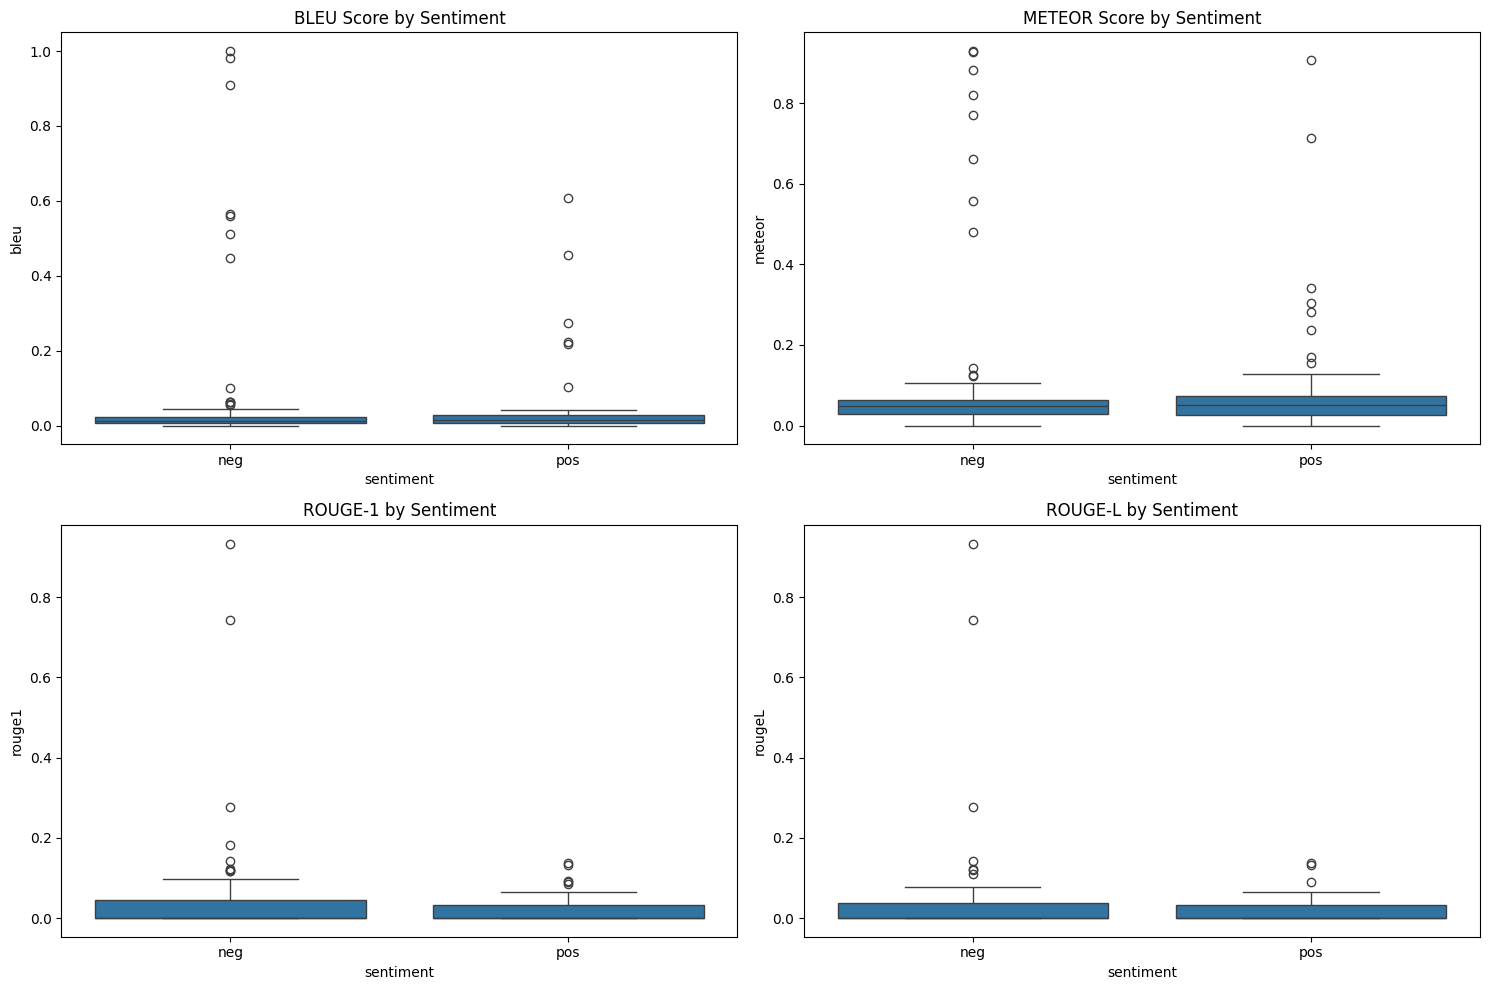

In [7]:
# 2.3b Evaluate Synthetic Text with Generation-Specific Metrics
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
from tqdm import tqdm

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Helper function for tokenizing text
def tokenize_for_metrics(text):
    return word_tokenize(text.lower())

# Calculate BLEU score between generated text and seed examples
def calculate_bleu(reference_texts, candidate_text):
    references = [tokenize_for_metrics(ref) for ref in reference_texts]
    candidate = tokenize_for_metrics(candidate_text)
    smoothing = SmoothingFunction().method1
    try:
        return sentence_bleu(references, candidate, smoothing_function=smoothing)
    except:
        return 0.0

# Calculate METEOR score
def calculate_meteor(reference_texts, candidate_text):
    references = [tokenize_for_metrics(ref) for ref in reference_texts]
    candidate = tokenize_for_metrics(candidate_text)
    try:
        return meteor_score(references, candidate)
    except:
        return 0.0

# Initialize Rouge scorer
rouge_scorer_instance = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
def calculate_rouge(reference_text, candidate_text):
    try:
        scores = rouge_scorer_instance.score(reference_text, candidate_text)
        return {
            'rouge1': scores['rouge1'].fmeasure,
            'rouge2': scores['rouge2'].fmeasure,
            'rougeL': scores['rougeL'].fmeasure
        }
    except:
        return {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}

# Evaluate synthetic data
print("Evaluating synthetic text quality...")
synthetic_quality_metrics = []

# Grab reference texts by sentiment
neg_references = seed_df[seed_df['sentiment'] == 'neg']['review'].tolist()
pos_references = seed_df[seed_df['sentiment'] == 'pos']['review'].tolist()

# For each synthetic text, calculate quality metrics
for idx, row in tqdm(synthetic_df.iterrows()):
    # Choose appropriate reference texts based on sentiment
    reference_texts = neg_references if row['sentiment'] == 'neg' else pos_references
    
    # Select 5 random references (or fewer if not enough available)
    sample_size = min(5, len(reference_texts))
    sampled_references = random.sample(reference_texts, sample_size)
    
    # Calculate metrics
    bleu_score = calculate_bleu(sampled_references, row['review'])
    meteor_score_val = calculate_meteor(sampled_references, row['review'])
    
    # Pick one reference for ROUGE calculation (ROUGE expects a single reference)
    sample_reference = random.choice(sampled_references)
    rouge_scores = calculate_rouge(sample_reference, row['review'])
    
    synthetic_quality_metrics.append({
        'idx': idx,
        'sentiment': row['sentiment'],
        'bleu': bleu_score,
        'meteor': meteor_score_val,
        'rouge1': rouge_scores['rouge1'],
        'rouge2': rouge_scores['rouge2'],
        'rougeL': rouge_scores['rougeL']
    })

# Convert to DataFrame
quality_df = pd.DataFrame(synthetic_quality_metrics)

# Visualize quality metrics
print("\nSynthetic Text Quality Metrics:")
print(quality_df.describe())

# Plot metrics by sentiment
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(data=quality_df, x='sentiment', y='bleu')
plt.title('BLEU Score by Sentiment')

plt.subplot(2, 2, 2)
sns.boxplot(data=quality_df, x='sentiment', y='meteor')
plt.title('METEOR Score by Sentiment')

plt.subplot(2, 2, 3)
sns.boxplot(data=quality_df, x='sentiment', y='rouge1')
plt.title('ROUGE-1 by Sentiment')

plt.subplot(2, 2, 4)
sns.boxplot(data=quality_df, x='sentiment', y='rougeL')
plt.title('ROUGE-L by Sentiment')

plt.tight_layout()
plt.savefig('Images/synthetic_text_quality_metrics.png')
plt.show()

# Add metrics to the synthetic data
synthetic_df = pd.merge(
    synthetic_df,
    quality_df[['idx', 'bleu', 'meteor', 'rouge1', 'rougeL']],
    left_index=True,
    right_on='idx'
)
synthetic_df.drop('idx', axis=1, inplace=True)

# Save metrics for future reference
quality_df.to_csv('Data/synthetic_text_quality_metrics.csv', index=False)

Loading augmented dataset...
Filtering synthetic data based on classifier confidence...


200it [00:00, 569.44it/s]


Kept 164 out of 200 synthetic examples


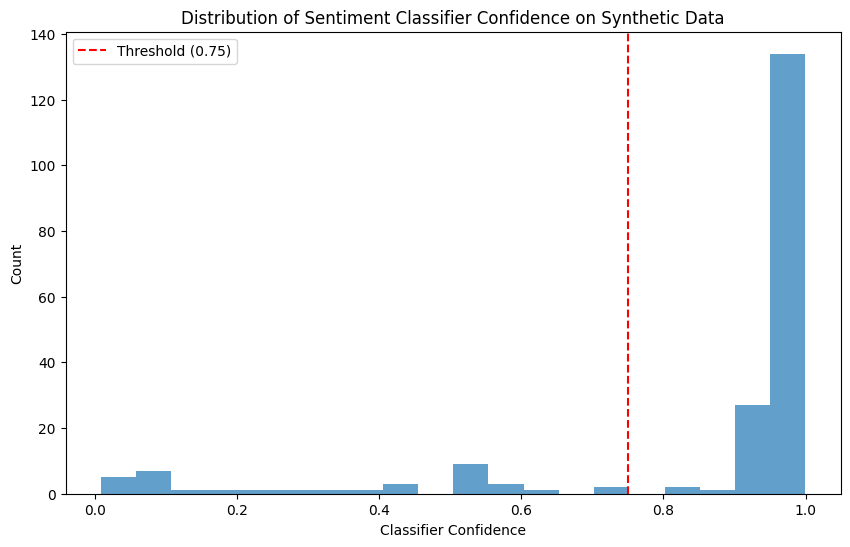

Original augmented dataset size: 300
Filtered augmented dataset size: 264


In [ ]:
# 2.4 Filter Synthetic Data by Quality
import fasttext
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

print("Loading augmented dataset...")
augmented_df = pd.read_csv('Data/augmented_dataset.csv')

# Separate seed data from synthetic data
seed_data = augmented_df.iloc[:len(seed_df)]
synthetic_data = augmented_df.iloc[len(seed_df):]

# Filter synthetic data based on classifier confidence
print("Filtering synthetic data based on classifier confidence...")
high_quality_indices = []
confidence_scores = []

for idx, row in tqdm(synthetic_data.iterrows()):
    target_label = '__label__' + row['sentiment']
    try:
        labels, probabilities = classifier.predict(row['review'], k=2)
        label_prob_dict = dict(zip(labels, probabilities))
        confidence = label_prob_dict.get(target_label, 0.0)
        confidence_scores.append(confidence)
        
        # Keep only high confidence examples (0.75 threshold)
        if confidence >= 0.75:
            high_quality_indices.append(idx)
    except Exception as e:
        continue

print(f"Kept {len(high_quality_indices)} out of {len(synthetic_data)} synthetic examples")

# Create filtered augmented dataset
filtered_synthetic_data = synthetic_data.loc[high_quality_indices]
filtered_augmented_df = pd.concat([seed_data, filtered_synthetic_data], ignore_index=True)
filtered_augmented_df.to_csv('Data/filtered_augmented_dataset.csv', index=False)

# Visualize confidence distribution
plt.figure(figsize=(10, 6))
plt.hist(confidence_scores, bins=20, alpha=0.7)
plt.axvline(x=0.75, color='r', linestyle='--', label='Threshold (0.75)')
plt.xlabel('Classifier Confidence')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Classifier Confidence on Synthetic Data')
plt.legend()
plt.savefig('Images/synthetic_data_quality.png')
plt.show()

print(f"Original augmented dataset size: {len(augmented_df)}")
print(f"Filtered augmented dataset size: {len(filtered_augmented_df)}")

In [ ]:
# 3.1 Fine-Tune and Evaluate BERT
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Load augmented dataset
augmented_df = pd.read_csv('Data/augmented_dataset.csv')

# Map sentiments to labels (pos: 1, neg: 0)
augmented_df['label'] = augmented_df['sentiment'].map({'pos': 1, 'neg': 0})

# Split into train and test sets
train_df, test_df = train_test_split(augmented_df, test_size=0.2, stratify=augmented_df['label'], random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['review', 'label']])
test_dataset = Dataset.from_pandas(test_df[['review', 'label']])

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2).to("cuda")

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples['review'], padding='max_length', truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Define compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1}

# Training arguments
training_args = TrainingArguments(
    output_dir='./Models/bert_finetuned',
    num_train_epochs=3,
    per_device_train_batch_size=8,  # Optimized for 6GB VRAM
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./Models/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True  # Mixed precision for VRAM efficiency
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate on test set
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

# Save the fine-tuned model
model.save_pretrained('Models/bert_finetuned')
tokenizer.save_pretrained('Models/bert_finetuned')

# Predict on test set for detailed metrics
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
accuracy = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average='weighted')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

2025-05-11 14:59:46.342573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-11 14:59:47.278377: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-11 14:59:47.610079: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-11 14:59:49.813875: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-11 14:59:58.636032: W tensorflow/compiler/tf2

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.667800,0.664762,0.566667,0.474191
2,0.589400,0.621488,0.616667,0.587704
3,0.383300,0.416851,0.850000,0.848531


Evaluation results: {'eval_loss': 0.4168510437011719, 'eval_accuracy': 0.85, 'eval_f1': 0.8485314685314685, 'eval_runtime': 0.5904, 'eval_samples_per_second': 101.634, 'eval_steps_per_second': 13.551, 'epoch': 3.0}
Test Accuracy: 0.8500
Test F1 Score: 0.8485


In [ ]:
# 3.1 Fine-Tune and Evaluate XLM-RoBERTa with Advanced Techniques
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load filtered augmented dataset
filtered_augmented_df = pd.read_csv('Data/augmented_dataset.csv')
filtered_augmented_df['label'] = filtered_augmented_df['sentiment'].map({'pos': 1, 'neg': 0})

# Split into train and test sets
train_df, test_df = train_test_split(filtered_augmented_df, test_size=0.2, stratify=filtered_augmented_df['label'], random_state=42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use XLM-RoBERTa instead of BERT for better multilingual performance
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['review', 'label']])
test_dataset = Dataset.from_pandas(test_df[['review', 'label']])

# Tokenize datasets with longer max length for better coverage
def tokenize_function(examples):
    return tokenizer(examples['review'], padding='max_length', truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Define compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1}

# First freeze the embedding layer and most transformer layers
for param in model.roberta.embeddings.parameters():
    param.requires_grad = False
    
for layer in model.roberta.encoder.layer[:-2]:  # Freeze all but last 2 layers
    for param in layer.parameters():
        param.requires_grad = False

# Stage 1 training arguments - train only top layers
training_args_stage1 = TrainingArguments(
    output_dir='./Models/xlm-roberta-stage1',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./Models/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True
)

# Early stopping callback
early_stopping = EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.01)

# Initialize Trainer
trainer_stage1 = Trainer(
    model=model,
    args=training_args_stage1,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

print("Stage 1: Training with frozen layers...")
trainer_stage1.train()

# Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Stage 2 training arguments - fine-tune all layers with smaller learning rate
training_args_stage2 = TrainingArguments(
    output_dir='./Models/xlm-roberta-stage2',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-6,  # Much smaller learning rate
    lr_scheduler_type="cosine",
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./Models/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True
)

# Create a new trainer for stage 2
trainer_stage2 = Trainer(
    model=model,
    args=training_args_stage2,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

print("Stage 2: Fine-tuning all layers...")
trainer_stage2.train()

# Final evaluation
eval_results = trainer_stage2.evaluate()
print(f"Evaluation results: {eval_results}")

# Save the fine-tuned model
model.save_pretrained('Models/xlm-roberta-finetuned')
tokenizer.save_pretrained('Models/xlm-roberta-finetuned')

# Get detailed metrics on test set
predictions = trainer_stage2.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
accuracy = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average='weighted')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

/home/Genai/project/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Stage 1: Training with frozen layers...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.692500,0.691414,0.516667,0.352015
2,0.694100,0.687069,0.516667,0.352015
3,0.695900,0.650102,0.700000,0.679904


/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Stage 2: Fine-tuning all layers...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.667600,0.654142,0.733333,0.720172
2,0.656500,0.622050,0.766667,0.766667
3,0.650800,0.611281,0.750000,0.739580
4,0.640700,0.576811,0.816667,0.815897
5,0.590200,0.574209,0.833333,0.832211


Evaluation results: {'eval_loss': 0.5742085576057434, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8322109988776655, 'eval_runtime': -0.843, 'eval_samples_per_second': -71.171, 'eval_steps_per_second': -9.489, 'epoch': 5.0}
Test Accuracy: 0.8333
Test F1 Score: 0.8322


In [ ]:
# 3.2 Model Evaluation and Comparison with Baseline
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Negative', 'Positive'],
           yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('Images/confusion_matrix.png')
plt.show()

# Train baseline model on original seed data only
print("\nEvaluating baseline model (trained on seed data only)...")

# Create seed-only datasets
seed_df_with_label = seed_df.copy()
seed_df_with_label['label'] = seed_df_with_label['sentiment'].map({'pos': 1, 'neg': 0})

baseline_train, baseline_test = train_test_split(
    seed_df_with_label, test_size=0.2, stratify=seed_df_with_label['label'], random_state=42
)

baseline_train_dataset = Dataset.from_pandas(baseline_train[['review', 'label']])
baseline_test_dataset = Dataset.from_pandas(baseline_test[['review', 'label']])

# Tokenize baseline datasets
baseline_train_dataset = baseline_train_dataset.map(tokenize_function, batched=True)
baseline_test_dataset = baseline_test_dataset.map(tokenize_function, batched=True)

baseline_train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
baseline_test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Create baseline model
baseline_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

# Baseline training arguments
baseline_args = TrainingArguments(
    output_dir='./Models/baseline-model',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./Models/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True
)

# Train baseline model
baseline_trainer = Trainer(
    model=baseline_model,
    args=baseline_args,
    train_dataset=baseline_train_dataset,
    eval_dataset=baseline_test_dataset,
    compute_metrics=compute_metrics
)

baseline_trainer.train()
baseline_results = baseline_trainer.evaluate()

# Get baseline metrics
baseline_predictions = baseline_trainer.predict(baseline_test_dataset)
baseline_preds = np.argmax(baseline_predictions.predictions, axis=1)
baseline_labels = baseline_predictions.label_ids
baseline_accuracy = accuracy_score(baseline_labels, baseline_preds)
baseline_f1 = f1_score(baseline_labels, baseline_preds, average='weighted')

# Print comparison
print("\n=== Performance Comparison ===")
print(f"Baseline (seed data only) - Accuracy: {baseline_accuracy:.4f}, F1: {baseline_f1:.4f}")
print(f"Enhanced (with synthetic) - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
print(f"Improvement              - Accuracy: {accuracy - baseline_accuracy:.4f}, F1: {f1 - baseline_f1:.4f}")

# Find error cases for analysis
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted'] = preds
test_df_with_preds['correct'] = test_df_with_preds['label'] == preds

# Print a few misclassified examples
print("\n=== Error Analysis ===")
misclassified = test_df_with_preds[~test_df_with_preds['correct']].sample(5)
for i, (_, row) in enumerate(misclassified.iterrows()):
    true_sentiment = "Positive" if row['label'] == 1 else "Negative"
    pred_sentiment = "Positive" if row['predicted'] == 1 else "Negative"
    print(f"Example {i+1}:")
    print(f"  True sentiment: {true_sentiment}")
    print(f"  Predicted sentiment: {pred_sentiment}")
    print(f"  Text: {row['review'][:100]}...")
    print()

# Plot accuracy by text length
test_df_with_preds['length'] = test_df_with_preds['review'].apply(len)
test_df_with_preds['length_group'] = pd.qcut(test_df_with_preds['length'], 4, labels=['Very Short', 'Short', 'Medium', 'Long'])
accuracy_by_length = test_df_with_preds.groupby('length_group')['correct'].mean()

plt.figure(figsize=(10, 6))
accuracy_by_length.plot(kind='bar', color='teal')
plt.title('Accuracy by Text Length')
plt.ylabel('Accuracy')
plt.xlabel('Text Length')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.savefig('Images/accuracy_by_length.png')
plt.show()

In [12]:
# 3.3a-1: Supervised Pre-training for GPT-2 before PPO - FIXED
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
import os
import gc

# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load GPT-2 base model and tokenizer
gpt2_model_name = "gpt2"
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_name)

# Add padding token
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model = GPT2LMHeadModel.from_pretrained(gpt2_model_name).to(device)
gpt2_model.resize_token_embeddings(len(gpt2_tokenizer))

# Create supervised training examples using seed_df
def create_training_examples(seed_df):
    examples = []
    # Create positive examples
    for _, row in seed_df[seed_df["sentiment"] == "pos"].iterrows():
        prompt = f"Generate a positive sentiment text in Roman Urdu:\n\n"
        response = row["review"]
        examples.append({
            "prompt": prompt,
            "response": response,
            "text": prompt + response  # Complete text for training
        })
    
    # Create negative examples
    for _, row in seed_df[seed_df["sentiment"] == "neg"].iterrows():
        prompt = f"Generate a negative sentiment text in Roman Urdu:\n\n"
        response = row["review"]
        examples.append({
            "prompt": prompt,
            "response": response,
            "text": prompt + response  # Complete text for training
        })
    
    return pd.DataFrame(examples)

train_df = create_training_examples(seed_df)
print(f"Created {len(train_df)} supervised training examples")

# Create dataset
dataset = Dataset.from_pandas(train_df)

# Prepare dataset for training with labels
def tokenize_function(examples):
    result = gpt2_tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)
    # Add labels for causal language modeling (identical to input_ids)
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    [col for col in tokenized_dataset.column_names if col not in ["input_ids", "attention_mask", "labels"]]
)
tokenized_dataset.set_format("torch")

# Define training arguments
training_args = TrainingArguments(
    output_dir="Models/gpt2_pretrained_roman_urdu",
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=4,
    save_steps=100,
    save_total_limit=2,
    logging_steps=10,
    fp16=True,  # Mixed precision for memory efficiency
)

# Create Trainer
trainer = Trainer(
    model=gpt2_model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=gpt2_tokenizer,
)

# Train the model
print("Starting supervised pre-training...")
trainer.train()

# Save the fine-tuned model
pretrained_model_path = "Models/gpt2_pretrained_roman_urdu"
gpt2_model.save_pretrained(pretrained_model_path)
gpt2_tokenizer.save_pretrained(pretrained_model_path)
print(f"Saved pre-trained model to {pretrained_model_path}")

# Clear memory
del gpt2_model, trainer
torch.cuda.empty_cache()
gc.collect()

Using device: cuda


/home/Genai/project/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Created 100 supervised training examples


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Starting supervised pre-training...


Step,Training Loss
10,7.341400
20,1.152400
30,0.957100
40,0.897400
50,0.934800


Saved pre-trained model to Models/gpt2_pretrained_roman_urdu


3650

Using device: cuda
Loading pre-trained Roman Urdu GPT-2 model from Models/gpt2_pretrained_roman_urdu


/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:257: UserWarning: No dataset is provided. Make sure to set config.batch_size to the correct value before training.
  warnings.warn(


Epoch 1/4

Example 0
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1275: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  std_scores = data["scores"].std()
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1302: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  stats["tokens/queries_len_std"] = torch.std(query_lens).cpu().numpy().item()
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1305: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/

Example 0, Reward: 0.0100
Current average reward: 0.0100

Example 1
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')

Example 2
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -24.98 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 3
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: h...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -27.76 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 4
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -22.45 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 5
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: p...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -23.47 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 6
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')

Example 7
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: f...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -24.83 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 8
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')

Example 9
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')

Example 10
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')
Example 10, Reward: 0.0100
Current average reward: 0.0100

Example 11
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')

Example 12
Generated text: Generate a new neg sentiment text in Roman Urdu that is different fr

/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -10.87 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 14
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -88.29 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 15
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: w...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -12.70 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 16
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: k...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -10.33 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 17
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: h...
Error in reward calculation: predict processes one line at a time (remove '\n')

Example 18
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: w...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -23.42 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 19
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: p...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -14.64 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 20
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -9.24 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 20, Reward: 0.0100
Current average reward: 0.0100

Example 21
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -59.88 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 22
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -24.21 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 23
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -90.90 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 24
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -107.76 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 25
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: l...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -19.26 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 26
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: t...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -56.14 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 27
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: l...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -45.49 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 28
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -188.44 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 29
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: p...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -51.60 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 30
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: l...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -66.52 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 30, Reward: 0.0100
Current average reward: 0.0100

Example 31
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: i...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8.75 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 32
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -151.27 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 33
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -111.15 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 34
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: f...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -40.04 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 35
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -86.49 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 36
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -40.67 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 37
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1:  ...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -231.50 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 38
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: l...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -90.34 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 39
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: p...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -13.08 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 40
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -20.78 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 40, Reward: 0.0100
Current average reward: 0.0100

Example 41
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -258.34 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 42
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: p...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -32.64 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 43
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -114.26 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 44
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -222.86 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 45
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: f...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -35.66 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 46
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -77.87 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 47
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -74.06 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 48
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: n...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -246.27 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 49
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -70.48 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 50
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -75.27 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 50, Reward: 0.0100
Current average reward: 0.0100

Example 51
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -35.90 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 52
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: j...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -130.17 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 53
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: ....
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -18.72 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 54
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: n...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -63.62 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 55
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: j...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -47.40 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 56
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -98.72 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 57
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -53.79 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 58
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -42.03 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 59
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -55.35 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 60
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -66.43 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 60, Reward: 0.0100
Current average reward: 0.0100

Example 61
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -275.85 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 62
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1:  ...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -54.45 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 63
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: v...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -239.53 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 64
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')

Example 65
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -71.69 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 66
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -100.12 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 67
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -75.63 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 68
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')

Example 69
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: k...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -87.90 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 70
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -272.01 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 70, Reward: 0.0100
Current average reward: 0.0100

Example 71
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: h...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -42.95 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 72
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -70.98 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 73
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -102.29 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 74
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: i...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -142.10 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 75
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -266.52 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 76
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -330.32 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 77
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: k...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -299.03 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 78
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -273.64 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 79
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: j...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -135.11 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 80
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: x...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -198.14 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 80, Reward: 0.0100
Current average reward: 0.0100

Example 81
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -133.93 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 82
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -194.66 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 83
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -141.10 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 84
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -121.12 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 85
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -166.14 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 86
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -124.21 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 87
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: h...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -337.57 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 88
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -205.59 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 89
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -357.23 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 90
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -247.40 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 90, Reward: 0.0100
Current average reward: 0.0100

Example 91
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -243.16 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 92
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -409.41 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 93
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -300.70 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 94
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: k...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -471.87 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 95
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: i...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -338.97 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 96
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -523.43 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 97
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -628.09 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 98
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -361.98 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 99
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -471.91 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Epoch 1 complete - Avg reward: 0.0100


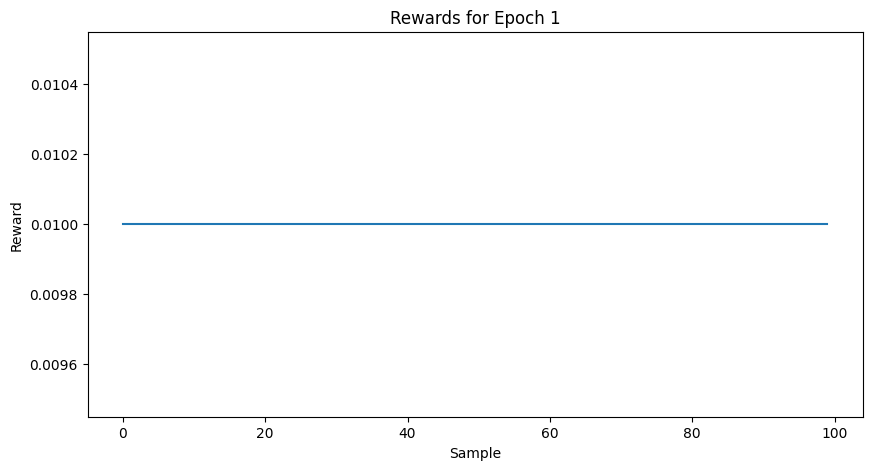

Epoch 2/4

Example 0
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -812.11 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 0, Reward: 0.0100
Current average reward: 0.0100

Example 1
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -334.36 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 2
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -518.98 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 3
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: h...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -997.47 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 4
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -850.10 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 5
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: p...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -647.72 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 6
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1167.02 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 7
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: f...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -998.56 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 8
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1175.61 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 9
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -895.11 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 10
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1255.75 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 10, Reward: 0.0100
Current average reward: 0.0100

Example 11
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1227.68 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 12
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1289.65 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 13
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1415.39 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 14
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -884.82 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 15
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: w...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1580.10 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 16
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: k...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1533.84 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 17
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: h...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1262.73 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 18
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: w...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1271.19 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 19
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: p...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1142.44 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 20
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1343.72 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 20, Reward: 0.0100
Current average reward: 0.0100

Example 21
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2126.77 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 22
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2462.48 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 23
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1955.68 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 24
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2019.83 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 25
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: l...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1540.81 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 26
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: t...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1699.82 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 27
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: l...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1835.62 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 28
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2309.47 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 29
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: p...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1745.84 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 30
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: l...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1776.74 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 30, Reward: 0.0100
Current average reward: 0.0100

Example 31
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: i...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1845.70 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 32
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2486.77 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 33
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1949.10 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 34
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: f...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1946.28 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 35
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2027.58 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 36
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2114.41 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 37
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1:  ...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3129.14 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 38
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: l...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2136.27 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 39
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: p...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2615.54 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 40
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -88.91 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 40, Reward: 0.0100
Current average reward: 0.0100

Example 41
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3030.67 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 42
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: p...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2907.71 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 43
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2645.82 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 44
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3278.03 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 45
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: f...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3010.09 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 46
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3140.98 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 47
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3349.38 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 48
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: n...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3858.98 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 49
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3583.88 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 50
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3241.14 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 50, Reward: 0.0100
Current average reward: 0.0100

Example 51
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3587.50 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 52
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: j...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -4177.50 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 53
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: ....
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3828.11 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 54
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: n...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3679.50 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 55
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: j...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -4199.14 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 56
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3972.97 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 57
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -4168.55 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 58
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -4256.32 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 59
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -4490.08 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 60
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -4362.72 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 60, Reward: 0.0100
Current average reward: 0.0100

Example 61
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5175.66 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 62
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1:  ...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -4747.87 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 63
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: v...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6102.66 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 64
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6072.50 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 65
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7364.40 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 66
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6667.94 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 67
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6776.68 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 68
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6646.82 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 69
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: k...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6853.81 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 70
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7411.35 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 70, Reward: 0.0100
Current average reward: 0.0100

Example 71
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: h...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6325.73 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 72
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7043.40 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 73
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6679.67 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 74
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: i...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6966.94 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 75
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7005.65 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 76
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6779.30 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 77
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: k...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7005.39 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 78
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7082.02 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 79
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: j...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6643.80 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 80
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: x...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6925.63 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 80, Reward: 0.0100
Current average reward: 0.0100

Example 81
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6739.36 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 82
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6711.41 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 83
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6652.06 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 84
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6644.99 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 85
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6702.24 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 86
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6180.04 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 87
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: h...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6850.10 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 88
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6421.19 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 89
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6590.76 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 90
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6499.62 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 90, Reward: 0.0100
Current average reward: 0.0100

Example 91
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7489.12 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 92
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7186.92 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 93
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7399.07 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 94
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: k...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8115.14 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 95
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: i...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6911.84 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 96
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7668.08 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 97
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7899.82 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 98
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7411.29 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 99
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7045.66 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Epoch 2 complete - Avg reward: 0.0100


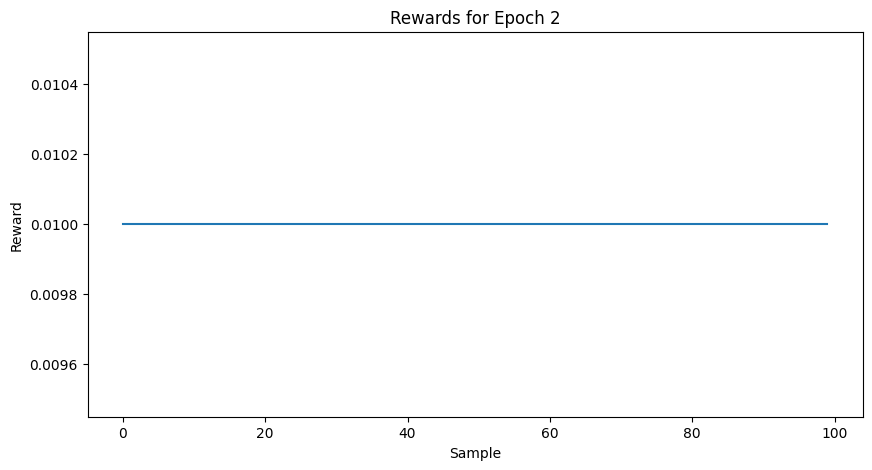

Epoch 3/4

Example 0
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1212: UserWarning: The average ratio of batch (39.74) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1212: UserWarning: The average ratio of batch (287.70) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -9340.34 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 0, Reward: 0.0100
Current average reward: 0.0100

Example 1
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6675.08 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 2
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7905.82 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 3
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: h...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7938.10 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 4
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6901.61 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 5
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: p...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6985.95 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 6
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7788.10 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 7
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: f...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7093.08 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 8
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7232.97 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 9
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6952.49 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 10
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8011.35 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 10, Reward: 0.0100
Current average reward: 0.0100

Example 11
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7630.59 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 12
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7482.06 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 13
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7404.42 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 14
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8921.66 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 15
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: w...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7519.17 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 16
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: k...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8505.67 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 17
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: h...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7864.98 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 18
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: w...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7779.40 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 19
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: p...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7853.19 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 20
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8085.15 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 20, Reward: 0.0100
Current average reward: 0.0100

Example 21
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8106.30 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 22
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -9156.08 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 23
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8545.97 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 24
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8364.20 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 25
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: l...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8560.62 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 26
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: t...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1212: UserWarning: The average ratio of batch (40.98) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1212: UserWarning: The average ratio of batch (21982.93) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1212: UserWarning: The average ratio of batch (1829834.50) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8834.20 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 27
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: l...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8612.05 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 28
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1212: UserWarning: The average ratio of batch (11.63) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1212: UserWarning: The average ratio of batch (40.20) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -9449.20 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 29
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: p...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8617.08 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 30
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: l...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7824.41 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 30, Reward: 0.0100
Current average reward: 0.0100

Example 31
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: i...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7611.50 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 32
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8903.48 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 33
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7426.16 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 34
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: f...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7854.48 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 35
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7995.38 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 36
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7439.92 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 37
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1:  ...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -9203.65 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 38
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: l...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7661.13 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 39
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: p...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7791.92 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 40
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -194.13 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 40, Reward: 0.0100
Current average reward: 0.0100

Example 41
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8019.47 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 42
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: p...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7520.72 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 43
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7588.19 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 44
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7814.22 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 45
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: f...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8103.74 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 46
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7795.93 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 47
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8145.68 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 48
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: n...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -9129.20 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 49
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1212: UserWarning: The average ratio of batch (14.67) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1212: UserWarning: The average ratio of batch (14746.66) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1212: UserWarning: The average ratio of batch (13410719.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -9405.23 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 50
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7981.60 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 50, Reward: 0.0100
Current average reward: 0.0100

Example 51
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8651.36 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 52
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: j...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8787.97 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 53
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: ....
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8592.33 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 54
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: n...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8271.72 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 55
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: j...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8559.55 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 56
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8038.97 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 57
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7981.46 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 58
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8081.65 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 59
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7790.71 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 60
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7403.61 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 60, Reward: 0.0100
Current average reward: 0.0100

Example 61
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8684.78 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 62
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1:  ...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8261.32 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 63
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: v...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8840.60 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 64
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8409.74 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 65
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8027.52 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 66
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7974.04 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 67
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8266.42 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 68
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8079.66 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 69
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: k...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7530.34 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 70
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8122.23 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 70, Reward: 0.0100
Current average reward: 0.0100

Example 71
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: h...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7412.56 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 72
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7379.24 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 73
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7549.05 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 74
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: i...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7212.57 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 75
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7284.98 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 76
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7678.09 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 77
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: k...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7385.67 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 78
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7282.01 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 79
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: j...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8309.98 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 80
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: x...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7183.60 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 80, Reward: 0.0100
Current average reward: 0.0100

Example 81
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7613.39 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 82
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7246.15 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 83
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7235.18 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 84
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7873.83 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 85
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7235.23 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 86
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6999.88 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 87
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: h...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7306.95 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 88
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7138.51 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 89
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7071.95 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 90
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6917.87 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 90, Reward: 0.0100
Current average reward: 0.0100

Example 91
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7909.59 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 92
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7540.00 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 93
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7411.00 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 94
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: k...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7729.89 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 95
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: i...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7159.32 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 96
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7717.20 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 97
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7656.86 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 98
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7126.68 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 99
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7812.29 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Epoch 3 complete - Avg reward: 0.0100


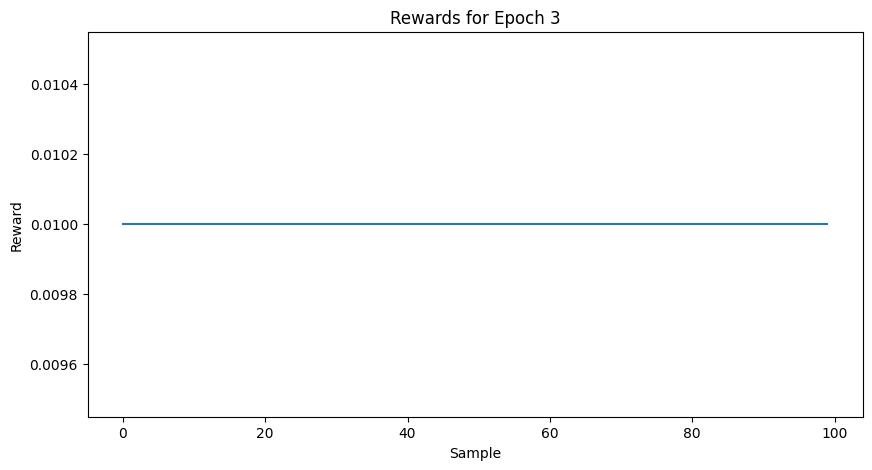

Epoch 4/4

Example 0
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7914.86 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 0, Reward: 0.0100
Current average reward: 0.0100

Example 1
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7380.91 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 2
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7241.97 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 3
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: h...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7550.67 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 4
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7080.69 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 5
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: p...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7368.81 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 6
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8084.02 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 7
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: f...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7164.38 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 8
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8260.78 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 9
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1212: UserWarning: The average ratio of batch (57.39) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1212: UserWarning: The average ratio of batch (2049.72) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8547.05 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 10
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7608.07 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 10, Reward: 0.0100
Current average reward: 0.0100

Example 11
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8214.25 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 12
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7189.27 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 13
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7140.92 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 14
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1212: UserWarning: The average ratio of batch (52.51) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1212: UserWarning: The average ratio of batch (5663.56) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1212: UserWarning: The average ratio of batch (379698.59) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -10638.12 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 15
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: w...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5943.62 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 16
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: k...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6969.31 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 17
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: h...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6817.56 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 18
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: w...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6750.17 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 19
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: p...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7110.02 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 20
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7451.75 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 20, Reward: 0.0100
Current average reward: 0.0100

Example 21
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7099.38 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 22
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8281.17 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 23
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: s...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7137.81 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 24
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7251.98 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 25
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: l...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6627.57 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 26
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: t...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6894.16 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 27
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: l...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6721.35 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 28
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7596.07 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 29
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: p...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7349.56 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 30
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: l...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7152.88 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 30, Reward: 0.0100
Current average reward: 0.0100

Example 31
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: i...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6830.76 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 32
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7602.46 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 33
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6542.71 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 34
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: f...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6471.82 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 35
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6373.19 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 36
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6373.41 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 37
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1:  ...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8151.41 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 38
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: l...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6568.14 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 39
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: p...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6647.46 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 40
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -333.41 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 40, Reward: 0.0100
Current average reward: 0.0100

Example 41
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7747.70 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 42
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: p...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7316.31 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 43
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6774.84 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 44
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7076.69 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 45
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: f...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6932.12 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 46
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6642.39 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 47
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7566.02 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 48
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: n...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7638.48 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 49
Generated text: Generate a new neg sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6613.21 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 50
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6603.42 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 50, Reward: 0.0100
Current average reward: 0.0100

Example 51
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7234.42 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 52
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: j...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7234.40 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 53
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: ....
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6654.25 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 54
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: n...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1212: UserWarning: The average ratio of batch (112.65) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1212: UserWarning: The average ratio of batch (243565.92) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1212: UserWarning: The average ratio of batch (602706048.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -9953.20 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 55
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: j...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7174.65 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 56
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7655.46 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 57
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1212: UserWarning: The average ratio of batch (12.99) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7618.69 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 58
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7178.64 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 59
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6975.51 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 60
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7296.86 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 60, Reward: 0.0100
Current average reward: 0.0100

Example 61
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7589.41 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 62
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1:  ...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8185.19 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 63
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: v...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7928.57 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 64
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7600.58 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 65
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7338.81 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 66
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7190.12 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 67
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7779.32 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 68
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6997.31 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 69
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: k...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7073.36 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 70
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7648.94 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 70, Reward: 0.0100
Current average reward: 0.0100

Example 71
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: h...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7046.65 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 72
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7124.26 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 73
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7219.03 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 74
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: i...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6983.82 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 75
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6986.76 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 76
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: y...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8045.00 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 77
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: k...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6927.48 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 78
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7083.78 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 79
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: j...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6951.30 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 80
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: x...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6662.43 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 80, Reward: 0.0100
Current average reward: 0.0100

Example 81
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6676.90 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 82
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6984.43 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 83
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: b...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7457.68 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 84
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7715.47 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 85
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7071.16 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 86
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: z...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7173.34 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 87
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: h...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6969.67 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 88
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7400.14 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 89
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7193.89 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 90
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: a...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6514.71 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Example 90, Reward: 0.0100
Current average reward: 0.0100

Example 91
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6825.93 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 92
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7831.40 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 93
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6456.95 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 94
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: k...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -7152.20 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 95
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: i...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6950.76 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 96
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6575.33 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 97
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: m...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6773.10 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 98
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: o...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6631.97 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(



Example 99
Generated text: Generate a new pos sentiment text in Roman Urdu that is different from these examples:

Example 1: d...
Error in reward calculation: predict processes one line at a time (remove '\n')


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6208.59 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Epoch 4 complete - Avg reward: 0.0100


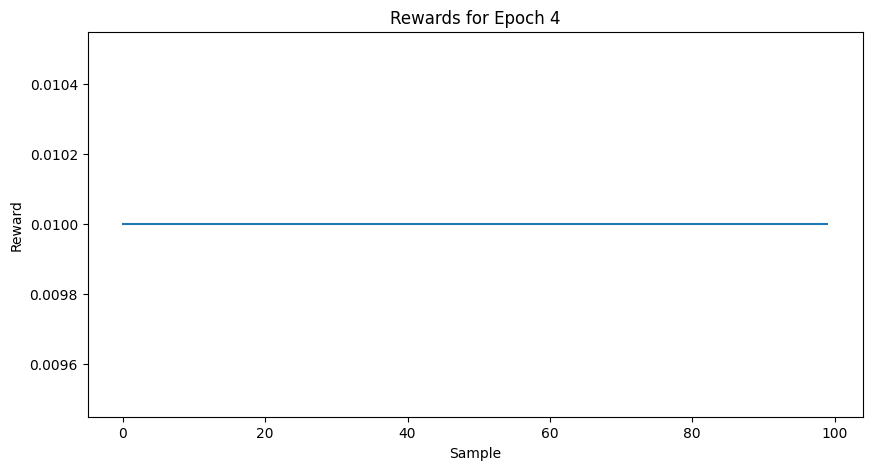

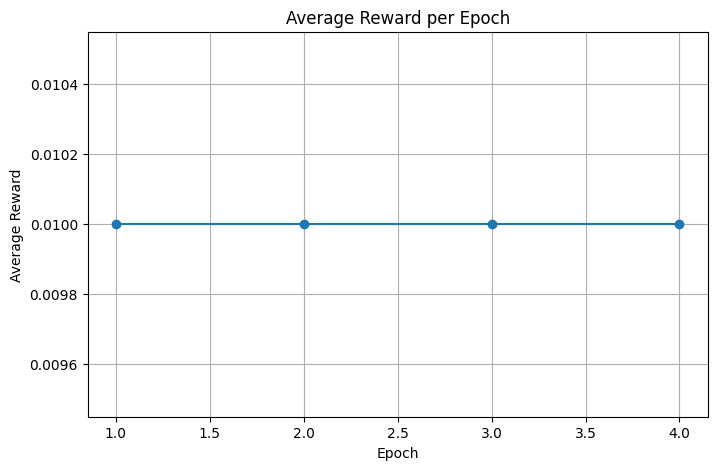

Saved PPO-finetuned GPT-2 model to ./Models/ppo_gpt2_small


In [20]:
# 3.3a-2: Improved PPO Fine-tune GPT-2 and Save Locally
from trl import PPOConfig, AutoModelForCausalLMWithValueHead, PPOTrainer
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import gc
import matplotlib.pyplot as plt
from collections import defaultdict
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Clear GPU memory first
torch.cuda.empty_cache()
gc.collect()

# Check if we have a pre-trained model, otherwise use standard GPT-2
pretrained_model_path = "Models/gpt2_pretrained_roman_urdu"
if os.path.exists(pretrained_model_path):
    print(f"Loading pre-trained Roman Urdu GPT-2 model from {pretrained_model_path}")
    gpt2_model_name = pretrained_model_path
else:
    print("Using standard GPT-2 model (pre-trained model not found)")
    gpt2_model_name = "gpt2"

# Load model and tokenizer
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_name)
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_tokenizer.padding_side = "left"

# Prepare PPO model
ppo_gpt2 = AutoModelForCausalLMWithValueHead.from_pretrained(gpt2_model_name).to(device)

ppo_config = PPOConfig(
    model_name=gpt2_model_name,
    learning_rate=5e-6,
    batch_size=1,
    mini_batch_size=1,
    ppo_epochs=4,
    gradient_accumulation_steps=1,
    kl_penalty="kl",
    init_kl_coef=0.2,
    adap_kl_ctrl=True
)

def gpt2_create_prompts(sentiment, num_prompts, seed_df):
    """
    Create prompts for GPT-2 specifically designed to reduce repetition and improve generation.
    """
    examples_df = seed_df[seed_df['sentiment'] == sentiment]
    prompts = []
    for _ in range(num_prompts):
        examples = examples_df.sample(2)
        prompt = f"Generate a new {sentiment} sentiment text in Roman Urdu that is different from these examples:\n\n"
        for i, (_, row) in enumerate(examples.iterrows()):
            prompt += f"Example {i+1}: {row['review']}\n\n"
        prompt += "Generated text:"
        prompts.append(prompt)
    return prompts

# Prepare prompts and targets
num_prompts_per_sentiment = 50
neg_prompts = gpt2_create_prompts('neg', num_prompts_per_sentiment, seed_df)
pos_prompts = gpt2_create_prompts('pos', num_prompts_per_sentiment, seed_df)
all_prompts = neg_prompts + pos_prompts
target_sentiments = ['neg'] * num_prompts_per_sentiment + ['pos'] * num_prompts_per_sentiment

# Tokenize prompts
tokenized_prompts = gpt2_tokenizer(all_prompts, padding=True, truncation=True, return_tensors="pt")
class PPODataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, prompts, sentiments):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.prompts = prompts
        self.sentiments = sentiments
    def __len__(self):
        return len(self.prompts)
    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "prompt": self.prompts[idx],
            "sentiment": self.sentiments[idx]
        }

ppo_dataset = PPODataset(
    tokenized_prompts['input_ids'],
    tokenized_prompts['attention_mask'],
    all_prompts,
    target_sentiments
)

ppo_trainer = PPOTrainer(
    config=ppo_config,
    model=ppo_gpt2,
    tokenizer=gpt2_tokenizer
)

# IMPROVED: Modified reward function to add small baseline reward instead of zero
def gpt2_get_reward(text, target_sentiment):
    if not text or len(text.strip()) == 0:
        return 0.01  # Small baseline reward instead of zero
    try:
        labels, probabilities = classifier.predict(text, k=2)
        label_prob_dict = dict(zip(labels, probabilities))
        target_label = '__label__' + target_sentiment
        reward = label_prob_dict.get(target_label, 0.0)
        # Add small baseline reward to prevent zero gradient
        return max(0.01, reward) if isinstance(reward, float) and reward >= 0 else 0.01
    except Exception as e:
        print(f"Error in reward calculation: {str(e)}")
        return 0.01

# tracking variables
reward_history = []
epoch_rewards = []
avg_rewards_per_epoch = []

for epoch in range(4):  # Can increase to 6 if VRAM allows
    print(f"Epoch {epoch+1}/4")
    epoch_reward = 0.0
    epoch_samples = 0
    epoch_rewards = []
    
    for idx in range(len(ppo_dataset)):
        example = ppo_dataset[idx]
        query_tensor = example["input_ids"].unsqueeze(0).to(device)
        attention_mask = example["attention_mask"].unsqueeze(0).to(device)
        
        with torch.no_grad():
            # IMPROVED: Adjusted generation parameters
            response_tensor = ppo_gpt2.generate(
                input_ids=query_tensor,
                attention_mask=attention_mask,
                max_length=query_tensor.shape[1] + 50,  # Shorter max length
                min_length=3,  # Allow shorter responses
                do_sample=True,
                top_k=50,
                top_p=0.98,  # Increased diversity
                temperature=1.0,  # Higher temperature for exploration
                repetition_penalty=1.2,
                no_repeat_ngram_size=2,  # Less restrictive
                pad_token_id=gpt2_tokenizer.eos_token_id
            )
            
        decoded_response = gpt2_tokenizer.decode(response_tensor[0], skip_special_tokens=True)
        
        # IMPROVED: Print generated text for debugging
        print(f"\nExample {idx}")
        print(f"Generated text: {decoded_response[:100]}...")
        
        reward = gpt2_get_reward(decoded_response, example["sentiment"])
        reward_history.append(reward)
        epoch_rewards.append(reward)
        
        # IMPROVED: Lower threshold for skipping examples
        if reward < 0.01:
            print(f"Skipping example {idx} with low reward: {reward:.4f}")
            continue
            
        rewards_tensor = torch.tensor([reward], device=device)
        stats = ppo_trainer.step([query_tensor[0]], [response_tensor[0]], [rewards_tensor])
        
        # Track statistics
        epoch_reward += reward
        epoch_samples += 1
        
        if idx % 10 == 0:
            print(f"Example {idx}, Reward: {reward:.4f}")
            current_avg = epoch_reward / max(1, epoch_samples)
            print(f"Current average reward: {current_avg:.4f}")
            torch.cuda.empty_cache()
    
    # End of epoch stats
    avg_epoch_reward = epoch_reward / max(1, epoch_samples)
    avg_rewards_per_epoch.append(avg_epoch_reward)
    print(f"Epoch {epoch+1} complete - Avg reward: {avg_epoch_reward:.4f}")
    
    # Plot rewards for this epoch
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_rewards)
    plt.title(f'Rewards for Epoch {epoch+1}')
    plt.xlabel('Sample')
    plt.ylabel('Reward')
    plt.savefig(f'Images/gpt2_epoch{epoch+1}_rewards.png')
    plt.show()
    
    # Memory management
    gc.collect()
    torch.cuda.empty_cache()

# Plot average rewards across epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(avg_rewards_per_epoch)+1), avg_rewards_per_epoch, marker='o')
plt.title('Average Reward per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Reward')
plt.grid(True)
plt.savefig('Images/gpt2_training_progress.png')
plt.show()

# Save PPO-finetuned GPT-2 model locally
ppo_gpt2.pretrained_model.save_pretrained("Models/ppo_gpt2_small")
gpt2_tokenizer.save_pretrained("Models/ppo_gpt2_small")
print("Saved PPO-finetuned GPT-2 model to ./Models/ppo_gpt2_small")

In [21]:
# 3.3 Generate Synthetic Data with PPO-Trained GPT-2 Model
import pandas as pd
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load PPO-trained GPT-2 model and tokenizer
gpt2_model = GPT2LMHeadModel.from_pretrained("Models/ppo_gpt2_small").to("cuda")
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("Models/ppo_gpt2_small")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token  # For padding

def gpt2_generate_synthetic_text(prompt, max_length=150):
    inputs = gpt2_tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to("cuda")
    outputs = gpt2_model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=inputs["input_ids"].shape[1] + max_length,
        do_sample=True,
        top_k=50,
        top_p=0.92,
        temperature=0.8,
        repetition_penalty=1.2,  # Add repetition penalty
        no_repeat_ngram_size=3,  # Prevent 3-gram repetition
        num_return_sequences=1,
        pad_token_id=gpt2_tokenizer.eos_token_id
    )
    
    generated_text = gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract just the generated part (after "Generated text:")
    if "Generated text:" in generated_text:
        return generated_text.split("Generated text:")[-1].strip()
    return generated_text

def gpt2_create_prompts(sentiment, num_prompts, seed_df):
    examples_df = seed_df[seed_df['sentiment'] == sentiment]
    prompts = []
    for _ in range(num_prompts):
        examples = examples_df.sample(2)
        prompt = f"Generate a new {sentiment} sentiment text in Roman Urdu that is different from these examples:\n\n"
        for i, (_, row) in enumerate(examples.iterrows()):
            prompt += f"Example {i+1}: {row['review']}\n\n"
        prompt += "Generated text:"
        prompts.append(prompt)
    return prompts

# Generate synthetic data
num_synthetic_per_sentiment = 100
neg_prompts = gpt2_create_prompts('neg', num_synthetic_per_sentiment, seed_df)
pos_prompts = gpt2_create_prompts('pos', num_synthetic_per_sentiment, seed_df)

gpt2_synthetic_texts = []
gpt2_synthetic_labels = []

for prompt in neg_prompts:
    text = gpt2_generate_synthetic_text(prompt)
    gpt2_synthetic_texts.append(text)
    gpt2_synthetic_labels.append('neg')

for prompt in pos_prompts:
    text = gpt2_generate_synthetic_text(prompt)
    gpt2_synthetic_texts.append(text)
    gpt2_synthetic_labels.append('pos')

gpt2_synthetic_df = pd.DataFrame({
    'review': gpt2_synthetic_texts,
    'sentiment': gpt2_synthetic_labels
})

# Combine with seed data
gpt2_augmented_df = pd.concat([seed_df, gpt2_synthetic_df], ignore_index=True)
gpt2_augmented_df.to_csv('Data/gpt2_augmented_dataset.csv', index=False)
print(f"Generated {len(gpt2_synthetic_df)} GPT-2 synthetic samples. Augmented dataset size: {len(gpt2_augmented_df)}")

Generated 200 GPT-2 synthetic samples. Augmented dataset size: 300


Evaluating GPT-2 synthetic text quality...


200it [00:00, 214.63it/s]



GPT-2 Synthetic Text Quality Metrics:
              idx   bleu  meteor  rouge1  rouge2  rougeL
count  200.000000  200.0   200.0   200.0   200.0   200.0
mean    99.500000    0.0     0.0     0.0     0.0     0.0
std     57.879185    0.0     0.0     0.0     0.0     0.0
min      0.000000    0.0     0.0     0.0     0.0     0.0
25%     49.750000    0.0     0.0     0.0     0.0     0.0
50%     99.500000    0.0     0.0     0.0     0.0     0.0
75%    149.250000    0.0     0.0     0.0     0.0     0.0
max    199.000000    0.0     0.0     0.0     0.0     0.0


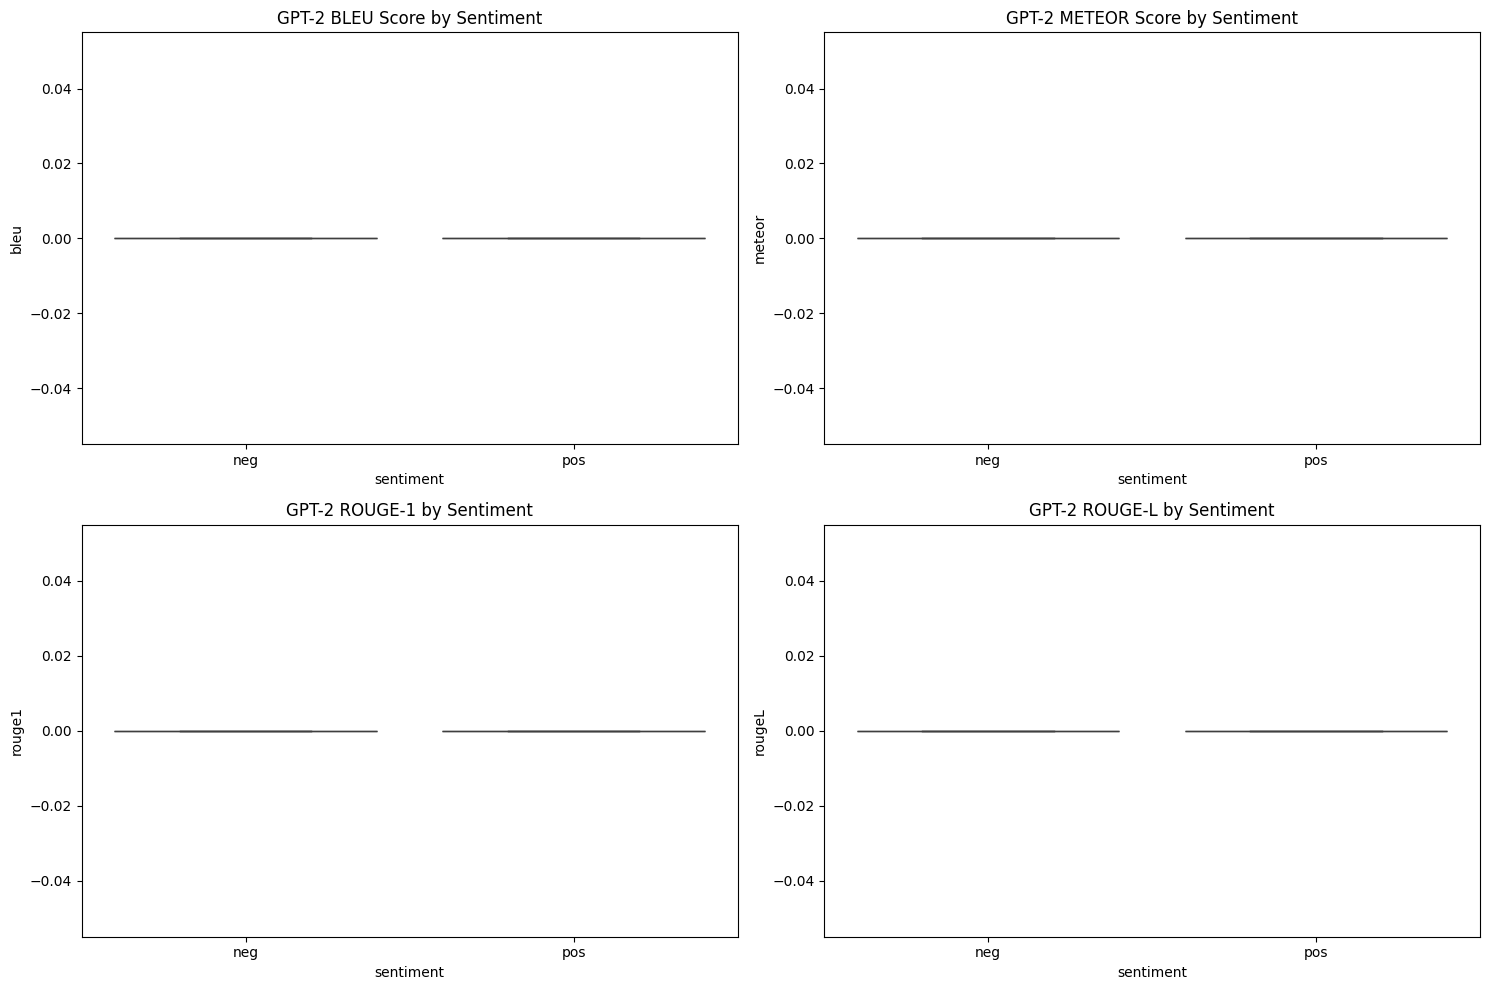

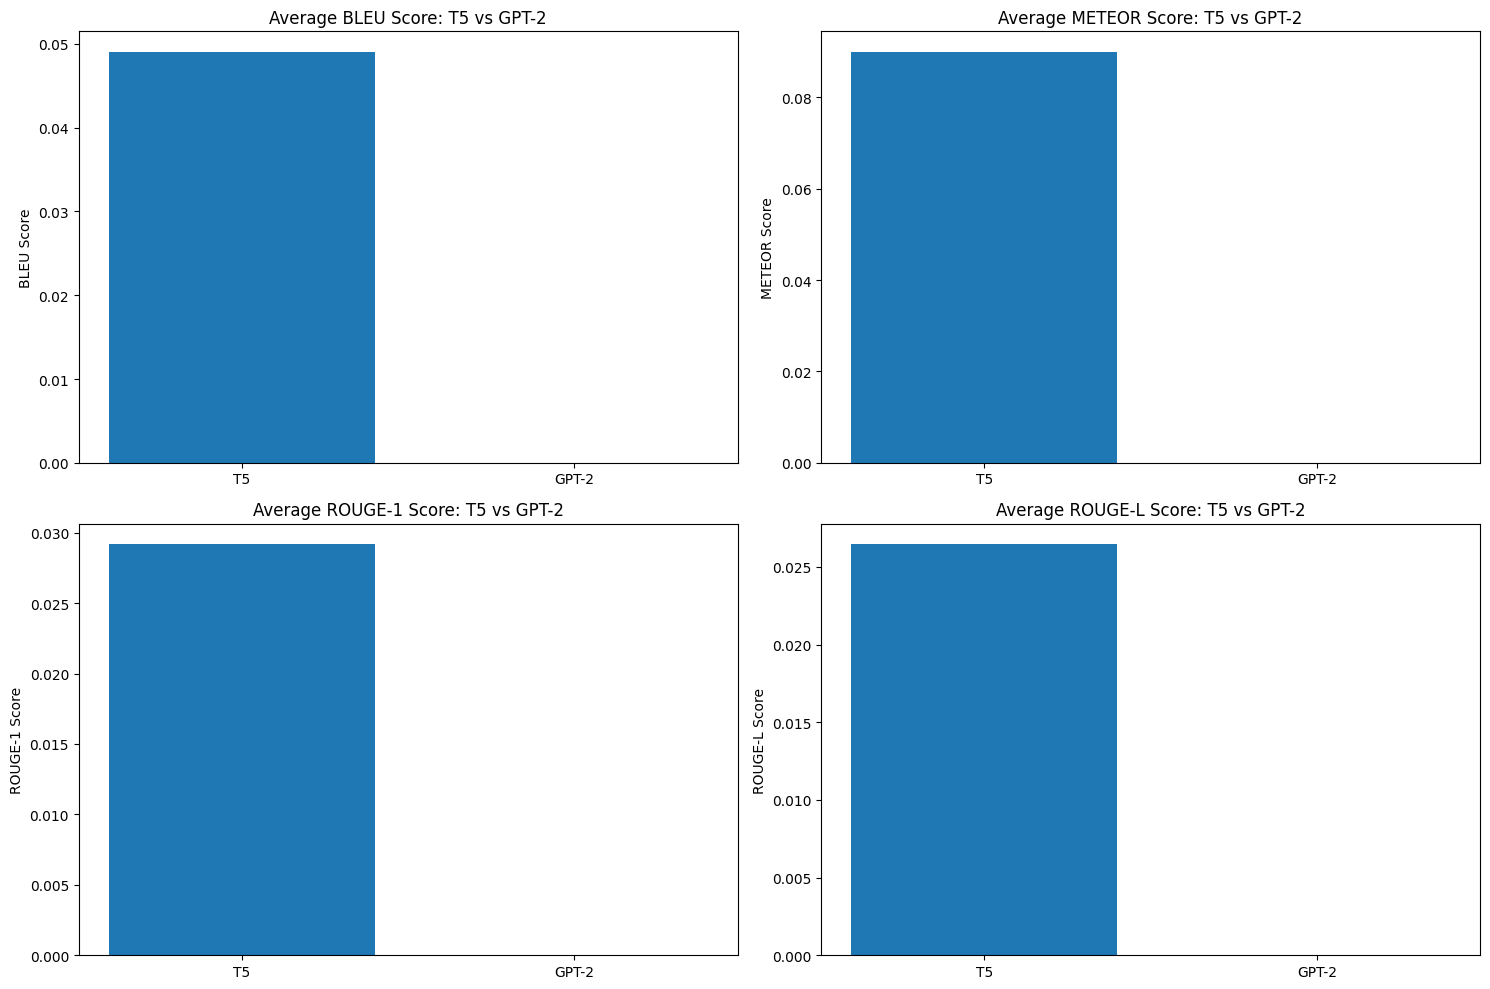

T5 vs GPT-2 Average Quality Metrics:
BLEU: T5 = 0.0491, GPT-2 = 0.0000
METEOR: T5 = 0.0900, GPT-2 = 0.0000
ROUGE-1: T5 = 0.0292, GPT-2 = 0.0000
ROUGE-L: T5 = 0.0264, GPT-2 = 0.0000


In [22]:
# 3.3b Evaluate GPT-2 Synthetic Text with Generation-Specific Metrics
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
from tqdm import tqdm

# Using the same helper functions already defined in cell 2.3b
# Evaluate GPT-2 synthetic data
print("Evaluating GPT-2 synthetic text quality...")
gpt2_synthetic_quality_metrics = []

# Grab reference texts by sentiment
neg_references = seed_df[seed_df['sentiment'] == 'neg']['review'].tolist()
pos_references = seed_df[seed_df['sentiment'] == 'pos']['review'].tolist()

# For each GPT-2 synthetic text, calculate quality metrics
for idx, row in tqdm(gpt2_synthetic_df.iterrows()):
    # Choose appropriate reference texts based on sentiment
    reference_texts = neg_references if row['sentiment'] == 'neg' else pos_references
    
    # Select 5 random references (or fewer if not enough available)
    sample_size = min(5, len(reference_texts))
    sampled_references = random.sample(reference_texts, sample_size)
    
    # Calculate metrics
    bleu_score = calculate_bleu(sampled_references, row['review'])
    meteor_score_val = calculate_meteor(sampled_references, row['review'])
    
    # Pick one reference for ROUGE calculation
    sample_reference = random.choice(sampled_references)
    rouge_scores = calculate_rouge(sample_reference, row['review'])
    
    gpt2_synthetic_quality_metrics.append({
        'idx': idx,
        'sentiment': row['sentiment'],
        'bleu': bleu_score,
        'meteor': meteor_score_val,
        'rouge1': rouge_scores['rouge1'],
        'rouge2': rouge_scores['rouge2'],
        'rougeL': rouge_scores['rougeL']
    })

# Convert to DataFrame
gpt2_quality_df = pd.DataFrame(gpt2_synthetic_quality_metrics)

# Visualize quality metrics
print("\nGPT-2 Synthetic Text Quality Metrics:")
print(gpt2_quality_df.describe())

# Plot metrics by sentiment
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(data=gpt2_quality_df, x='sentiment', y='bleu')
plt.title('GPT-2 BLEU Score by Sentiment')

plt.subplot(2, 2, 2)
sns.boxplot(data=gpt2_quality_df, x='sentiment', y='meteor')
plt.title('GPT-2 METEOR Score by Sentiment')

plt.subplot(2, 2, 3)
sns.boxplot(data=gpt2_quality_df, x='sentiment', y='rouge1')
plt.title('GPT-2 ROUGE-1 by Sentiment')

plt.subplot(2, 2, 4)
sns.boxplot(data=gpt2_quality_df, x='sentiment', y='rougeL')
plt.title('GPT-2 ROUGE-L by Sentiment')

plt.tight_layout()
plt.savefig('Images/gpt2_synthetic_text_quality_metrics.png')
plt.show()

# Add metrics to the GPT-2 synthetic data
gpt2_synthetic_df = pd.merge(
    gpt2_synthetic_df,
    gpt2_quality_df[['idx', 'bleu', 'meteor', 'rouge1', 'rougeL']],
    left_index=True,
    right_on='idx'
)
gpt2_synthetic_df.drop('idx', axis=1, inplace=True)

# Save metrics for future reference
gpt2_quality_df.to_csv('Data/gpt2_synthetic_text_quality_metrics.csv', index=False)

# Compare T5 vs GPT-2 quality metrics
plt.figure(figsize=(15, 10))

# BLEU score comparison
plt.subplot(2, 2, 1)
t5_bleu = quality_df['bleu'].mean()
gpt2_bleu = gpt2_quality_df['bleu'].mean()
plt.bar(['T5', 'GPT-2'], [t5_bleu, gpt2_bleu])
plt.title('Average BLEU Score: T5 vs GPT-2')
plt.ylabel('BLEU Score')

# METEOR score comparison
plt.subplot(2, 2, 2)
t5_meteor = quality_df['meteor'].mean()
gpt2_meteor = gpt2_quality_df['meteor'].mean()
plt.bar(['T5', 'GPT-2'], [t5_meteor, gpt2_meteor])
plt.title('Average METEOR Score: T5 vs GPT-2')
plt.ylabel('METEOR Score')

# ROUGE-1 score comparison
plt.subplot(2, 2, 3)
t5_rouge1 = quality_df['rouge1'].mean()
gpt2_rouge1 = gpt2_quality_df['rouge1'].mean()
plt.bar(['T5', 'GPT-2'], [t5_rouge1, gpt2_rouge1])
plt.title('Average ROUGE-1 Score: T5 vs GPT-2')
plt.ylabel('ROUGE-1 Score')

# ROUGE-L score comparison
plt.subplot(2, 2, 4)
t5_rougeL = quality_df['rougeL'].mean()
gpt2_rougeL = gpt2_quality_df['rougeL'].mean()
plt.bar(['T5', 'GPT-2'], [t5_rougeL, gpt2_rougeL])
plt.title('Average ROUGE-L Score: T5 vs GPT-2')
plt.ylabel('ROUGE-L Score')

plt.tight_layout()
plt.savefig('Images/t5_vs_gpt2_quality_comparison.png')
plt.show()

print("T5 vs GPT-2 Average Quality Metrics:")
print(f"BLEU: T5 = {t5_bleu:.4f}, GPT-2 = {gpt2_bleu:.4f}")
print(f"METEOR: T5 = {t5_meteor:.4f}, GPT-2 = {gpt2_meteor:.4f}")
print(f"ROUGE-1: T5 = {t5_rouge1:.4f}, GPT-2 = {gpt2_rouge1:.4f}")
print(f"ROUGE-L: T5 = {t5_rougeL:.4f}, GPT-2 = {gpt2_rougeL:.4f}")

Loading GPT-2 augmented dataset...
Filtering GPT-2 synthetic data based on classifier confidence...


200it [00:00, 11318.98it/s]

Kept 99 out of 200 GPT-2 synthetic examples


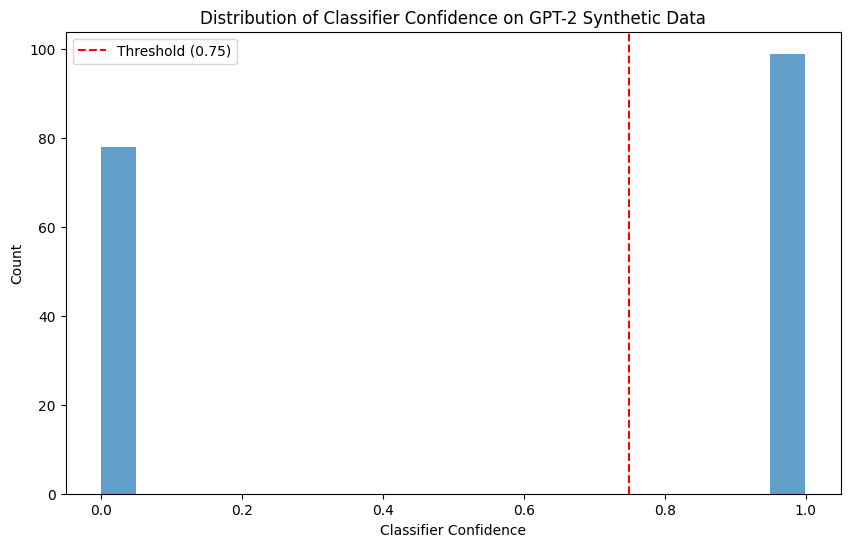

Original GPT-2 augmented dataset size: 300
Filtered GPT-2 augmented dataset size: 199


In [23]:
# 3.4 Filter GPT-2 Synthetic Data by Quality
import fasttext
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

print("Loading GPT-2 augmented dataset...")
gpt2_augmented_df = pd.read_csv('Data/gpt2_augmented_dataset.csv')

# Separate seed data from synthetic data
seed_data = gpt2_augmented_df.iloc[:len(seed_df)]
synthetic_data = gpt2_augmented_df.iloc[len(seed_df):]

print("Filtering GPT-2 synthetic data based on classifier confidence...")
high_quality_indices = []
confidence_scores = []

for idx, row in tqdm(synthetic_data.iterrows()):
    target_label = '__label__' + row['sentiment']
    try:
        labels, probabilities = classifier.predict(row['review'], k=2)
        label_prob_dict = dict(zip(labels, probabilities))
        confidence = label_prob_dict.get(target_label, 0.0)
        confidence_scores.append(confidence)
        if confidence >= 0.75:
            high_quality_indices.append(idx)
    except Exception as e:
        continue

print(f"Kept {len(high_quality_indices)} out of {len(synthetic_data)} GPT-2 synthetic examples")

filtered_synthetic_data = synthetic_data.loc[high_quality_indices]
filtered_gpt2_augmented_df = pd.concat([seed_data, filtered_synthetic_data], ignore_index=True)
filtered_gpt2_augmented_df.to_csv('Data/gpt2_filtered_augmented_dataset.csv', index=False)

plt.figure(figsize=(10, 6))
plt.hist(confidence_scores, bins=20, alpha=0.7)
plt.axvline(x=0.75, color='r', linestyle='--', label='Threshold (0.75)')
plt.xlabel('Classifier Confidence')
plt.ylabel('Count')
plt.title('Distribution of Classifier Confidence on GPT-2 Synthetic Data')
plt.legend()
plt.savefig('Images/gpt2_synthetic_data_quality.png')
plt.show()

print(f"Original GPT-2 augmented dataset size: {len(gpt2_augmented_df)}")
print(f"Filtered GPT-2 augmented dataset size: {len(filtered_gpt2_augmented_df)}")

In [25]:
# 3.5 Fine-Tune and Evaluate BERT on GPT-2 Synthetic Data - FIXED
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Load GPT-2 augmented dataset
gpt2_augmented_df = pd.read_csv('Data/gpt2_augmented_dataset.csv')

# Check if review column exists
print(f"Columns in dataset: {gpt2_augmented_df.columns.tolist()}")

# Data cleaning - ensure reviews are strings and handle NaN values
print(f"Initial shape: {gpt2_augmented_df.shape}")
print(f"NaN values in 'review' column: {gpt2_augmented_df['review'].isna().sum()}")

# Clean the data: convert all to strings and fill NA values
gpt2_augmented_df['review'] = gpt2_augmented_df['review'].fillna("").astype(str)

# Check for empty strings
empty_reviews = (gpt2_augmented_df['review'] == "").sum()
print(f"Empty review strings: {empty_reviews}")

# Map sentiments to labels (pos: 1, neg: 0)
gpt2_augmented_df['label'] = gpt2_augmented_df['sentiment'].map({'pos': 1, 'neg': 0})

# Split into train and test sets
train_df, test_df = train_test_split(gpt2_augmented_df, test_size=0.2, stratify=gpt2_augmented_df['label'], random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['review', 'label']])
test_dataset = Dataset.from_pandas(test_df[['review', 'label']])

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2).to("cuda")

# Tokenize datasets with safer handling
def tokenize_function(examples):
    # Double-check that inputs are strings
    texts = [str(text) for text in examples['review']]
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1}

training_args = TrainingArguments(
    output_dir='./Models/bert_finetuned_gpt2',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./Models/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

model.save_pretrained('Models/bert_finetuned_gpt2')
tokenizer.save_pretrained('Models/bert_finetuned_gpt2')

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
accuracy = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average='weighted')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Columns in dataset: ['sentiment', 'review', 'text_length', 'synonym_replacement', 'random_insertion', 'random_swap', 'random_deletion']
Initial shape: (300, 7)
NaN values in 'review' column: 23
Empty review strings: 23


/home/Genai/project/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.674200,0.722668,0.600000,0.514637
2,0.675800,0.683004,0.600000,0.514637
3,0.638200,0.644725,0.600000,0.586111


Checkpoint destination directory ./Models/bert_finetuned_gpt2/checkpoint-30 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./Models/bert_finetuned_gpt2/checkpoint-60 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./Models/bert_finetuned_gpt2/checkpoint-90 already exists and is non-empty. Saving will proceed but saved results may be invalid.


Evaluation results: {'eval_loss': 0.6447245478630066, 'eval_accuracy': 0.6, 'eval_f1': 0.586111111111111, 'eval_runtime': 1.7943, 'eval_samples_per_second': 33.44, 'eval_steps_per_second': 4.459, 'epoch': 3.0}
Test Accuracy: 0.6000
Test F1 Score: 0.5861


In [26]:
# 3.6 Fine-Tune and Evaluate XLM-RoBERTa on Filtered GPT-2 Synthetic Data
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load filtered GPT-2 augmented dataset
filtered_gpt2_augmented_df = pd.read_csv('Data/gpt2_filtered_augmented_dataset.csv')
filtered_gpt2_augmented_df['label'] = filtered_gpt2_augmented_df['sentiment'].map({'pos': 1, 'neg': 0})

train_df, test_df = train_test_split(filtered_gpt2_augmented_df, test_size=0.2, stratify=filtered_gpt2_augmented_df['label'], random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

train_dataset = Dataset.from_pandas(train_df[['review', 'label']])
test_dataset = Dataset.from_pandas(test_df[['review', 'label']])

def tokenize_function(examples):
    return tokenizer(examples['review'], padding='max_length', truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1}

# Freeze all but last 2 layers
for param in model.roberta.embeddings.parameters():
    param.requires_grad = False
for layer in model.roberta.encoder.layer[:-2]:
    for param in layer.parameters():
        param.requires_grad = False

training_args_stage1 = TrainingArguments(
    output_dir='./Models/xlm-roberta-gpt2-stage1',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./Models/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.01)

trainer_stage1 = Trainer(
    model=model,
    args=training_args_stage1,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

print("Stage 1: Training with frozen layers...")
trainer_stage1.train()

# Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

training_args_stage2 = TrainingArguments(
    output_dir='./Models/xlm-roberta-gpt2-stage2',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-6,
    lr_scheduler_type="cosine",
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./Models/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True
)

trainer_stage2 = Trainer(
    model=model,
    args=training_args_stage2,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

print("Stage 2: Fine-tuning all layers...")
trainer_stage2.train()

eval_results = trainer_stage2.evaluate()
print(f"Evaluation results: {eval_results}")

model.save_pretrained('Models/xlm-roberta-finetuned-gpt2')
tokenizer.save_pretrained('Models/xlm-roberta-finetuned-gpt2')

predictions = trainer_stage2.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
accuracy = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average='weighted')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

/home/Genai/project/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/159 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Stage 1: Training with frozen layers...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.676400,0.666943,0.775000,0.676761
2,0.620800,0.627026,0.775000,0.676761
3,0.587600,0.560742,0.775000,0.676761


Checkpoint destination directory ./Models/xlm-roberta-gpt2-stage1/checkpoint-20 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Stage 2: Fine-tuning all layers...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.656300,0.657373,0.775000,0.676761
2,0.618000,0.629700,0.775000,0.676761
3,0.550600,0.450998,0.775000,0.676761


Checkpoint destination directory ./Models/xlm-roberta-gpt2-stage2/checkpoint-20 already exists and is non-empty. Saving will proceed but saved results may be invalid.


Evaluation results: {'eval_loss': 0.6573730707168579, 'eval_accuracy': 0.775, 'eval_f1': 0.6767605633802816, 'eval_runtime': 0.7266, 'eval_samples_per_second': 55.048, 'eval_steps_per_second': 6.881, 'epoch': 3.0}
Test Accuracy: 0.7750
Test F1 Score: 0.6768


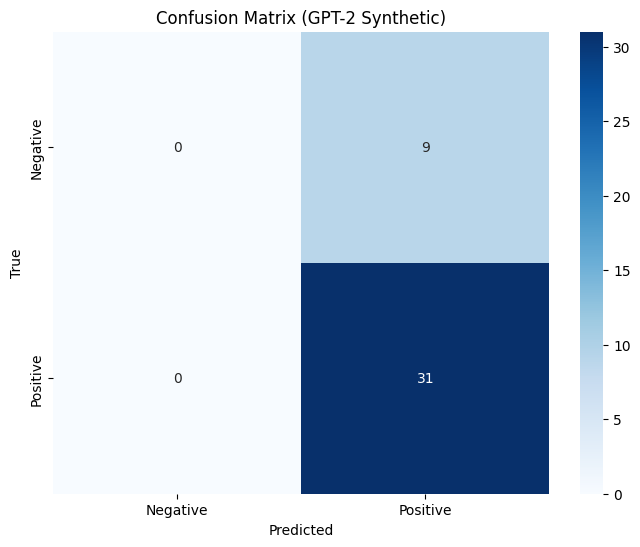


Evaluating baseline model (seed data only, for GPT-2 comparison)...


/home/Genai/project/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.am

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.721000,0.716113,0.450000,0.279310
2,0.709600,0.711279,0.450000,0.279310
3,0.706900,0.709448,0.450000,0.279310


Checkpoint destination directory ./Models/baseline-model-gpt2/checkpoint-10 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./Models/baseline-model-gpt2/checkpoint-20 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./Models/baseline-model-gpt2/checkpoint-30 already exists and is non-empty. Saving will proceed but saved results may be invalid.



=== Performance Comparison (GPT-2 Synthetic) ===
Baseline (seed data only) - Accuracy: 0.4500, F1: 0.2793
Enhanced (with GPT-2 synthetic) - Accuracy: 0.7750, F1: 0.6768
Improvement              - Accuracy: 0.3250, F1: 0.3975

=== Error Analysis (GPT-2 Synthetic) ===
Example 1:
  True sentiment: Negative
  Predicted sentiment: Positive
  Text: paise zaya ...

Example 2:
  True sentiment: Negative
  Predicted sentiment: Positive
  Text: ye tu dewrani jethani ki nok ghonk he saas akr muk muka kr de gi . ...

Example 3:
  True sentiment: Negative
  Predicted sentiment: Positive
  Text:  .. in k han koi kutta b marry to ilzam pakistan py he lagaty hai in sy kia takra .. ...

Example 4:
  True sentiment: Negative
  Predicted sentiment: Positive
  Text: iqbal ham sharminda hein . aap ki chuti ke qatil zinda hein . ...

Example 5:
  True sentiment: Negative
  Predicted sentiment: Positive
  Text: yaar iss tarha ki posting kar kay aap kiun antipti ki g per sigrat lagatay hoabhi dekhnatarrap ka

/tmp/ipykernel_960/909524252.py:107: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_length = test_df_with_preds.groupby('length_group')['correct'].mean()


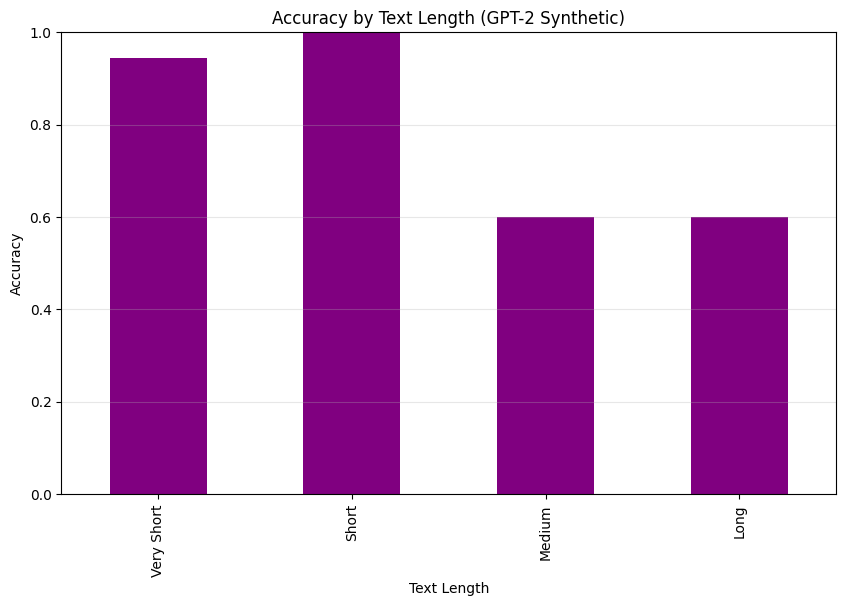

In [32]:
# 3.7 Model Evaluation and Comparison with Baseline (GPT-2 Synthetic Data)
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Negative', 'Positive'],
           yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (GPT-2 Synthetic)')
plt.savefig('Images/confusion_matrix_gpt2.png')
plt.show()

# Baseline on seed data
print("\nEvaluating baseline model (seed data only, for GPT-2 comparison)...")
seed_df_with_label = seed_df.copy()
seed_df_with_label['label'] = seed_df_with_label['sentiment'].map({'pos': 1, 'neg': 0})

baseline_train, baseline_test = train_test_split(
    seed_df_with_label, test_size=0.2, stratify=seed_df_with_label['label'], random_state=42
)

baseline_train_dataset = Dataset.from_pandas(baseline_train[['review', 'label']])
baseline_test_dataset = Dataset.from_pandas(baseline_test[['review', 'label']])

# Define tokenizer here before using it in tokenize_function
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define tokenize_function that explicitly uses the tokenizer variable
def tokenize_baseline_function(examples):
    return tokenizer(examples['review'], padding='max_length', truncation=True, max_length=256)

baseline_train_dataset = baseline_train_dataset.map(tokenize_baseline_function, batched=True)
baseline_test_dataset = baseline_test_dataset.map(tokenize_baseline_function, batched=True)

baseline_train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
baseline_test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

baseline_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

baseline_args = TrainingArguments(
    output_dir='./Models/baseline-model-gpt2',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./Models/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True
)

baseline_trainer = Trainer(
    model=baseline_model,
    args=baseline_args,
    train_dataset=baseline_train_dataset,
    eval_dataset=baseline_test_dataset,
    compute_metrics=compute_metrics
)

baseline_trainer.train()
baseline_results = baseline_trainer.evaluate()

baseline_predictions = baseline_trainer.predict(baseline_test_dataset)
baseline_preds = np.argmax(baseline_predictions.predictions, axis=1)
baseline_labels = baseline_predictions.label_ids
baseline_accuracy = accuracy_score(baseline_labels, baseline_preds)
baseline_f1 = f1_score(baseline_labels, baseline_preds, average='weighted')

print("\n=== Performance Comparison (GPT-2 Synthetic) ===")
print(f"Baseline (seed data only) - Accuracy: {baseline_accuracy:.4f}, F1: {baseline_f1:.4f}")
print(f"Enhanced (with GPT-2 synthetic) - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
print(f"Improvement              - Accuracy: {accuracy - baseline_accuracy:.4f}, F1: {f1 - baseline_f1:.4f}")

# Error analysis
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted'] = preds
test_df_with_preds['correct'] = test_df_with_preds['label'] == preds

print("\n=== Error Analysis (GPT-2 Synthetic) ===")
misclassified = test_df_with_preds[~test_df_with_preds['correct']].sample(5)
for i, (_, row) in enumerate(misclassified.iterrows()):
    true_sentiment = "Positive" if row['label'] == 1 else "Negative"
    pred_sentiment = "Positive" if row['predicted'] == 1 else "Negative"
    print(f"Example {i+1}:")
    print(f"  True sentiment: {true_sentiment}")
    print(f"  Predicted sentiment: {pred_sentiment}")
    print(f"  Text: {row['review'][:100]}...")
    print()

test_df_with_preds['length'] = test_df_with_preds['review'].apply(len)
test_df_with_preds['length_group'] = pd.qcut(test_df_with_preds['length'], 4, labels=['Very Short', 'Short', 'Medium', 'Long'])
accuracy_by_length = test_df_with_preds.groupby('length_group')['correct'].mean()

plt.figure(figsize=(10, 6))
accuracy_by_length.plot(kind='bar', color='purple')
plt.title('Accuracy by Text Length (GPT-2 Synthetic)')
plt.ylabel('Accuracy')
plt.xlabel('Text Length')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.savefig('Images/accuracy_by_length_gpt2.png')
plt.show()

In [29]:
# Code to free GPU memory completely
import torch
import gc

# Delete any existing model variables (add specific model variables you know exist)
try:
    del model, tokenizer, trainer, model_with_value_head
    del baseline_model, baseline_trainer, ppo_gpt2, gpt2_model 
except:
    pass

# Clear cache and collect garbage
torch.cuda.empty_cache()
gc.collect()

# Check current GPU memory usage
print(f"Current GPU memory usage: {torch.cuda.memory_allocated()/1e9:.2f} GB")

Current GPU memory usage: 10.58 GB
